In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
#new_saver.save(sess, "../models/niger-current/model")

In [3]:
new_saver = tf.train.import_meta_graph('../models/february-fused-master-west-africa-dry/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/february-fused-master-west-africa-dry/'))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/february-fused-master-west-africa-dry/model


In [4]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    #EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    #br = (br[0] + 20, br[1] + 20)
    #tl = (tl[0] - 20, tl[1] - 20)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


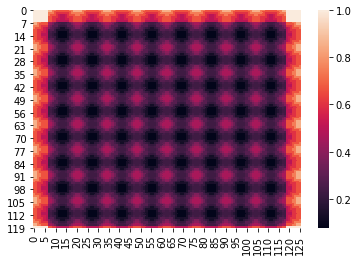

In [5]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



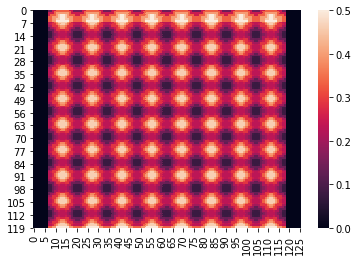

In [6]:
sns.heatmap(right_filter)

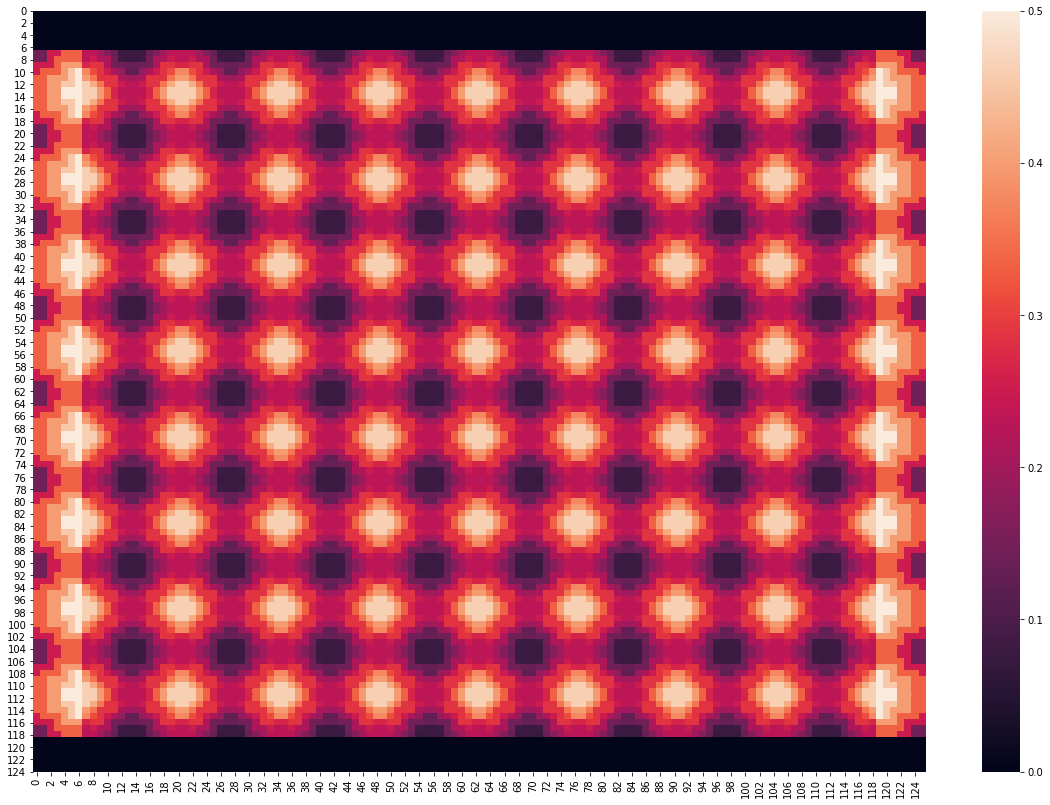

In [7]:
plt.figure(figsize=(20, 14))
sns.heatmap(up_filter)

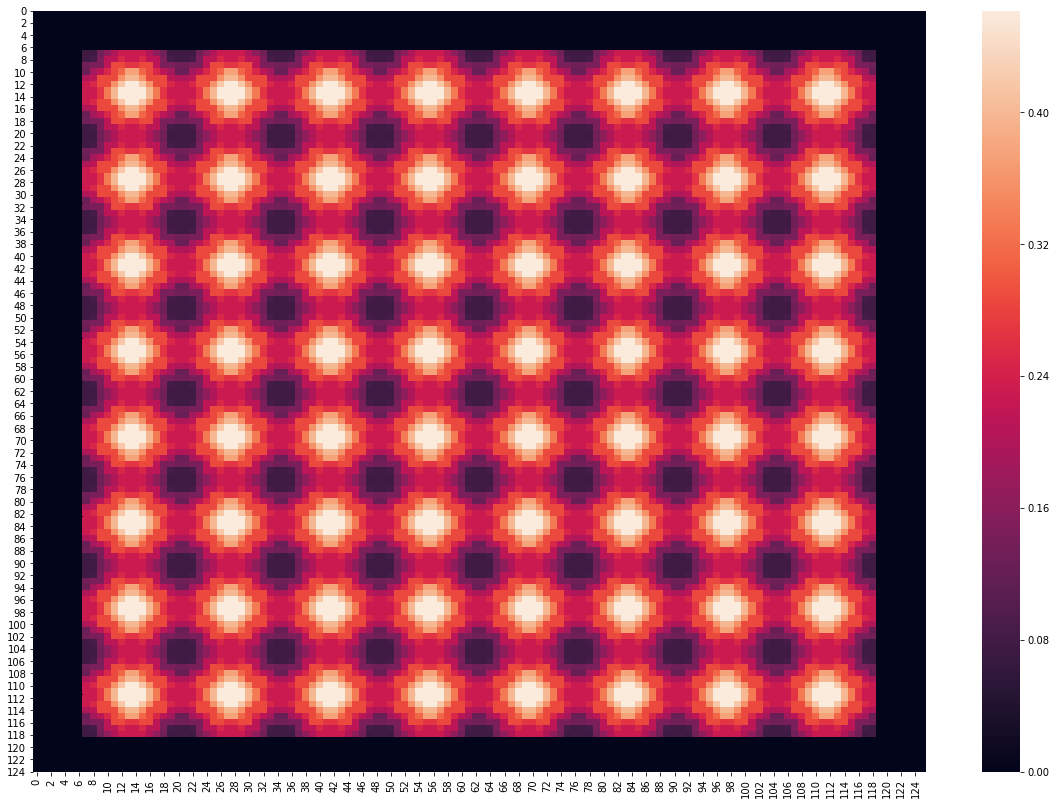

In [8]:
plt.figure(figsize=(20, 14))
sns.heatmap(upright[:, :])

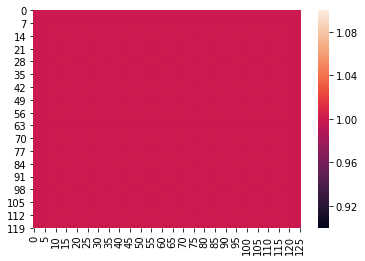

In [9]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(sum_filter)

In [10]:
np.tile(np.array(24), (24, 1)).shape

(24, 1)

In [11]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
min_all = [0.020041798930615185,
 0.037792792804539205,
 0.022476176451891663,
 0.08548464052379132,
 0.05650158278644085,
 0.07740494482219219,
 0.0840544743090868,
 0.08622615240514278,
 0.0706351237744093,
 0.0427229817584157,
 0.0,
 0.006563705061562359,
 -0.01744983049109578,
 0.005225462089292703,
  0.0063749998807907104,
 0.0001250000059371814]

max_all = [0.18134129151701867,
 0.27378561437129956,
 0.4014175131916998,
 0.4868263602256775,
 0.45080901354551306,
 0.4679806348681449,
 0.49490821748971936,
 0.5116603970527649,
 0.6328844583034514,
 0.5591901928186414,
 0.3618685007095337,
 0.697949901819229,
 0.3965708017349243,
 0.6338821130990981,
 0.815,
 0.145]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)



def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    #pred_files = ["../data/oregon/" + str(y_col) + "/" + str(folder) + "/" + str(x) + ".npy" for x in range(1, TOTAL+1)]
    pred_files = ["../tile_data/cameroon/" + str(y_col) + "/" + str(folder) + ".npy"]
    #pred_x = np.empty((0, 24, 16, 16, 14))
    pred_x = []

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        #if x.shape[0] < 24:
        #    padding = np.tile(x[-1, :, :, :], (24-x.shape[0], 1, 1, 1))
        #    x = np.concatenate((x, padding), axis = 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))

    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        #lengths = np.array(24).tile((batch_x.shape[0], 1))
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    #stacked = stacked / sum_filter
    return stacked

In [12]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [13]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [14]:
x = np.load("../tile_data/cameroon/0/0.npy")






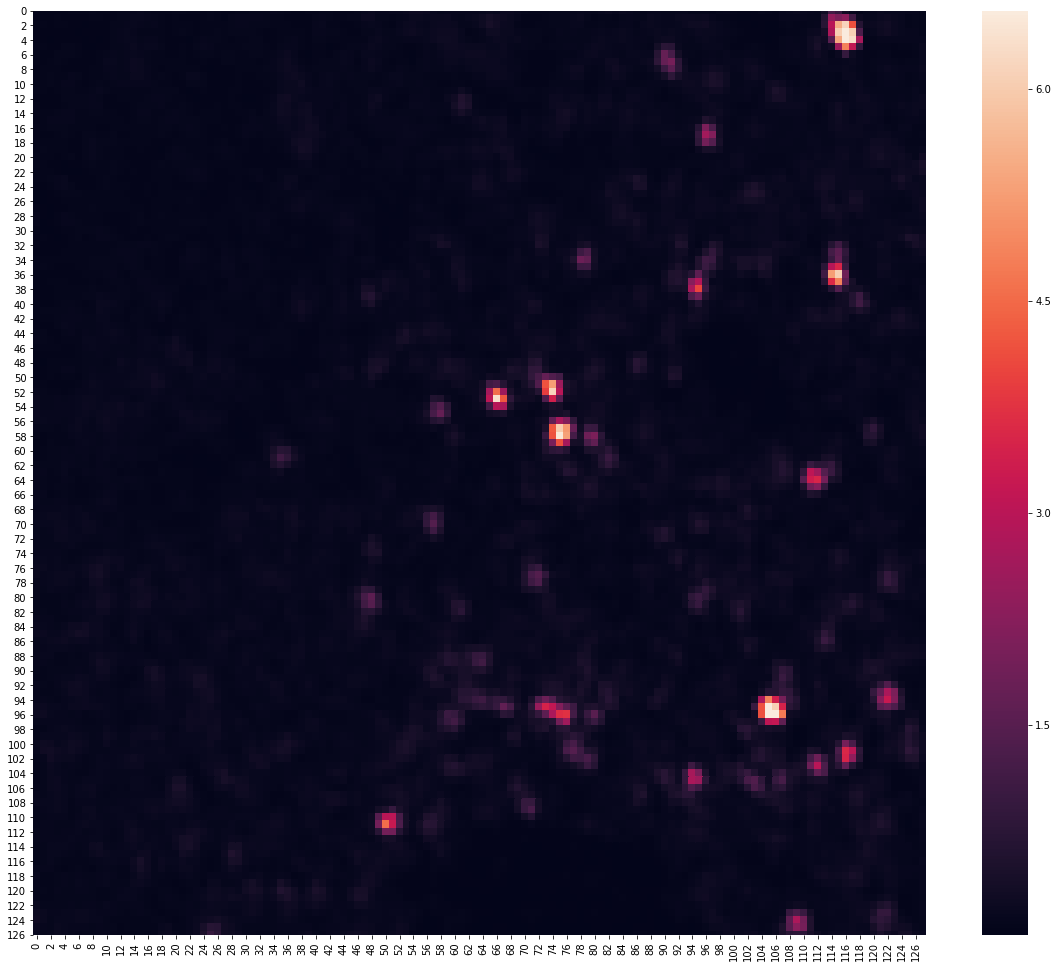

In [15]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[15, :, :, 15])




In [22]:
from time import sleep
all_preds = []
for row in tnrange(0,15):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 20)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

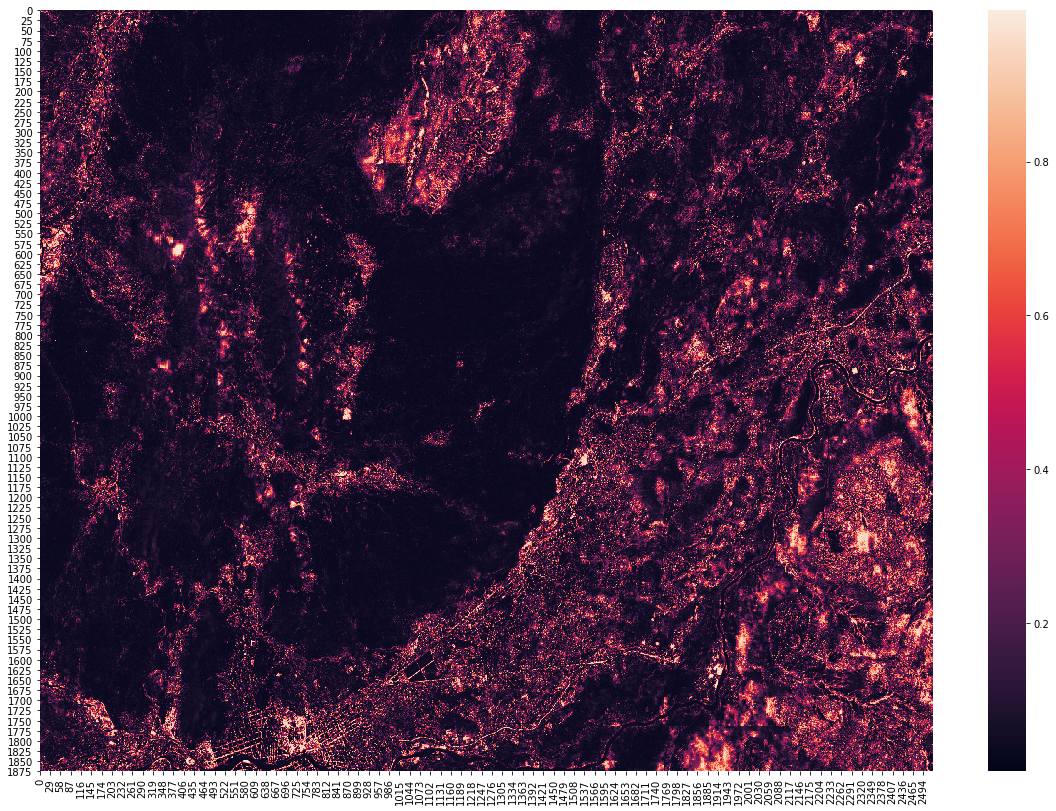

In [23]:
stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 14))
sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

In [24]:
thresh = 0.25 # .4, .44 for makueni, 65, 75 for kochi
thresh_p = 0.5

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh and cur_window[4, 2] < thresh:
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh and cur_window[2, 4] < thresh:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh and cur_window[1, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh and cur_window[3, 1] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

Adding a tree with: 0.40832824707031257
Adding a tree with: 0.2902645468711853
Adding a tree with: 0.27200746536254883
Adding a tree with: 0.51
Adding a tree with: 0.2688450396060944
Adding a tree with: 0.4615962386131287
Adding a tree with: 0.4179384052753449
Adding a tree with: 0.2699798345565796
Adding a tree with: 0.35057386159896853
Adding a tree with: 0.3404729664325714
Adding a tree with: 0.51
Adding a tree with: 0.4012700815995534
Adding a tree with: 0.25267723798751834
Adding a tree with: 0.45808300375938416
Adding a tree with: 0.28343652188777924
Adding a tree with: 0.366636298596859
Adding a tree with: 0.48273028433322906
Adding a tree with: 0.2866588830947876
Adding a tree with: 0.2904810681939125
Adding a tree with: 0.26915348321199417
Adding a tree with: 0.2957598209381104
Adding a tree with: 0.51
Adding a tree with: 0.32241789499918616
Adding a tree with: 0.51
Adding a tree with: 0.45248363614082343
Adding a tree with: 0.2588808238506317
Adding a tree with: 0.26886065304

Adding a tree with: 0.25910452206929524
Adding a tree with: 0.25180895511920637
Adding a tree with: 0.36204307125164914
Adding a tree with: 0.2660371979077657
Adding a tree with: 0.4221765100955963
Adding a tree with: 0.31173179929073036
Adding a tree with: 0.43317483480160046
Adding a tree with: 0.51
Adding a tree with: 0.29102248450120294
Adding a tree with: 0.3034698704878489
Adding a tree with: 0.51
Adding a tree with: 0.3049362485225384
Adding a tree with: 0.3247905579897074
Adding a tree with: 0.38005926211675
Adding a tree with: 0.3203376571337382
Adding a tree with: 0.51
Adding a tree with: 0.25941954851150517
Adding a tree with: 0.45227462301651633
Adding a tree with: 0.4223117828369141
Adding a tree with: 0.36315178232533596
Adding a tree with: 0.4055745850006739
Adding a tree with: 0.51
Adding a tree with: 0.2547566959491142
Adding a tree with: 0.4769516204084669
Adding a tree with: 0.2745071819850377
Adding a tree with: 0.39196912518569405
Adding a tree with: 0.319007011560

Adding a tree with: 0.3596090567963464
Adding a tree with: 0.3542473465204239
Adding a tree with: 0.41833375580608845
Adding a tree with: 0.4496632516384125
Adding a tree with: 0.3566911369562149
Adding a tree with: 0.4040308929979801
Adding a tree with: 0.37421924993395805
Adding a tree with: 0.28014112583228523
Adding a tree with: 0.2752028051763773
Adding a tree with: 0.25090186670422554
Adding a tree with: 0.51
Adding a tree with: 0.2898884955793619
Adding a tree with: 0.46821150396551414
Adding a tree with: 0.38966497778892517
Adding a tree with: 0.3826054409146309
Adding a tree with: 0.2811534319605146
Adding a tree with: 0.3462157491594553
Adding a tree with: 0.29912539944052696
Adding a tree with: 0.36071834340691566
Adding a tree with: 0.4202309735119343
Adding a tree with: 0.3836559924212369
Adding a tree with: 0.2633966909987586
Adding a tree with: 0.2890041470527649
Adding a tree with: 0.40597046485969
Adding a tree with: 0.51
Adding a tree with: 0.33574462682008743
Adding 

Adding a tree with: 0.359497532248497
Adding a tree with: 0.3187764241145207
Adding a tree with: 0.25091249247392017
Adding a tree with: 0.4068458239237468
Adding a tree with: 0.28831098400629485
Adding a tree with: 0.3217408175651843
Adding a tree with: 0.29563817183176677
Adding a tree with: 0.4113955406042245
Adding a tree with: 0.3742246375634119
Adding a tree with: 0.31786817082991964
Adding a tree with: 0.34430092802414525
Adding a tree with: 0.51
Adding a tree with: 0.29799300202956563
Adding a tree with: 0.51
Adding a tree with: 0.4435072311988243
Adding a tree with: 0.36363696058591205
Adding a tree with: 0.51
Adding a tree with: 0.35110108057657874
Adding a tree with: 0.2655663788318634
Adding a tree with: 0.51
Adding a tree with: 0.266395268531946
Adding a tree with: 0.51
Adding a tree with: 0.4230822563171387
Adding a tree with: 0.51
Adding a tree with: 0.31981869844289923
Adding a tree with: 0.3765178254017462
Adding a tree with: 0.34085058314459665
Adding a tree with: 0.4

Adding a tree with: 0.29289255291223526
Adding a tree with: 0.39549623616039753
Adding a tree with: 0.51
Adding a tree with: 0.2801334006445749
Adding a tree with: 0.4755653105676174
Adding a tree with: 0.51
Adding a tree with: 0.4599255025386811
Adding a tree with: 0.3226983270474843
Adding a tree with: 0.40670144557952886
Adding a tree with: 0.3814084785325187
Adding a tree with: 0.39140216580459064
Adding a tree with: 0.4373360999992916
Adding a tree with: 0.2964351006916591
Adding a tree with: 0.2841651397092002
Adding a tree with: 0.51
Adding a tree with: 0.25258466388498035
Adding a tree with: 0.4453733095100948
Adding a tree with: 0.279467020715986
Adding a tree with: 0.4947605490684509
Adding a tree with: 0.3362623240266528
Adding a tree with: 0.51
Adding a tree with: 0.4840704245226724
Adding a tree with: 0.4862884793962752
Adding a tree with: 0.34471144846507484
Adding a tree with: 0.2964857625109809
Adding a tree with: 0.51
Adding a tree with: 0.2505663803645543
Adding a tre

Adding a tree with: 0.42920229583978653
Adding a tree with: 0.32020603617032367
Adding a tree with: 0.2628450791041056
Adding a tree with: 0.2881676355997721
Adding a tree with: 0.51
Adding a tree with: 0.3618980422616005
Adding a tree with: 0.3547508418560028
Adding a tree with: 0.35809851686159766
Adding a tree with: 0.3330215017000834
Adding a tree with: 0.361707866191864
Adding a tree with: 0.31206598452159334
Adding a tree with: 0.4283892938068935
Adding a tree with: 0.38377872854471207
Adding a tree with: 0.3628356258074442
Adding a tree with: 0.3281514048576355
Adding a tree with: 0.51
Adding a tree with: 0.33375519514083857
Adding a tree with: 0.34536221623420715
Adding a tree with: 0.4695674180984497
Adding a tree with: 0.51
Adding a tree with: 0.28875741362571716
Adding a tree with: 0.51
Adding a tree with: 0.3278530921254839
Adding a tree with: 0.3217412616525377
Adding a tree with: 0.51
Adding a tree with: 0.28948753078778583
Adding a tree with: 0.2726985684462956
Adding a 

Adding a tree with: 0.3551408563341414
Adding a tree with: 0.51
Adding a tree with: 0.31414035601275314
Adding a tree with: 0.4683765292167664
Adding a tree with: 0.51
Adding a tree with: 0.28346282669476097
Adding a tree with: 0.2659370281866619
Adding a tree with: 0.3374595085779826
Adding a tree with: 0.33989330274718155
Adding a tree with: 0.25674327462911606
Adding a tree with: 0.51
Adding a tree with: 0.43814288824796677
Adding a tree with: 0.51
Adding a tree with: 0.2795735597610474
Adding a tree with: 0.26144556403160096
Adding a tree with: 0.44075470566749575
Adding a tree with: 0.4269239136150905
Adding a tree with: 0.4453296895538057
Adding a tree with: 0.4932094854967935
Adding a tree with: 0.40266966422398887
Adding a tree with: 0.3193151823111943
Adding a tree with: 0.390189536412557
Adding a tree with: 0.3104043517793928
Adding a tree with: 0.3096374909083049
Adding a tree with: 0.2627412655523845
Adding a tree with: 0.3637577082429613
Adding a tree with: 0.4338366772447

Adding a tree with: 0.36442236602306366
Adding a tree with: 0.37687829732894895
Adding a tree with: 0.41144891083240503
Adding a tree with: 0.3236769277315873
Adding a tree with: 0.27095251129223746
Adding a tree with: 0.2773046652475993
Adding a tree with: 0.29767455045993507
Adding a tree with: 0.4358736534913381
Adding a tree with: 0.41148446287427626
Adding a tree with: 0.29671349892249466
Adding a tree with: 0.3430691957473755
Adding a tree with: 0.2665509680906931
Adding a tree with: 0.28362829410112816
Adding a tree with: 0.3496001729598412
Adding a tree with: 0.3626952721522404
Adding a tree with: 0.37833196841753436
Adding a tree with: 0.2643659183612236
Adding a tree with: 0.25342033306757605
Adding a tree with: 0.3877362981438637
Adding a tree with: 0.29292192061742145
Adding a tree with: 0.3501006166140238
Adding a tree with: 0.51
Adding a tree with: 0.25017428856629587
Adding a tree with: 0.3735386798015007
Adding a tree with: 0.51
Adding a tree with: 0.3558449665705363
Ad

Adding a tree with: 0.38488876447081566
Adding a tree with: 0.3970371037721634
Adding a tree with: 0.42400138080120087
Adding a tree with: 0.2502453454903194
Adding a tree with: 0.40094195678830147
Adding a tree with: 0.51
Adding a tree with: 0.4661019090563059
Adding a tree with: 0.4219246357679367
Adding a tree with: 0.35552378211702623
Adding a tree with: 0.3793216794729233
Adding a tree with: 0.28760107047855854
Adding a tree with: 0.28866470232605934
Adding a tree with: 0.29729198664426804
Adding a tree with: 0.38274675235152245
Adding a tree with: 0.28381990455091
Adding a tree with: 0.384151394878115
Adding a tree with: 0.2652698755264282
Adding a tree with: 0.27085409845624653
Adding a tree with: 0.2926316176142012
Adding a tree with: 0.3837444093078375
Adding a tree with: 0.4401986024209432
Adding a tree with: 0.2991646118462086
Adding a tree with: 0.2648178189992905
Adding a tree with: 0.31393465772271156
Adding a tree with: 0.2730742543935776
Adding a tree with: 0.4040221795

Adding a tree with: 0.28868023019570566
Adding a tree with: 0.3540510286887487
Adding a tree with: 0.31393684102938724
Adding a tree with: 0.2743064348514263
Adding a tree with: 0.34936039952131415
Adding a tree with: 0.29478284219900774
Adding a tree with: 0.3882982043119576
Adding a tree with: 0.43841839234034224
Adding a tree with: 0.51
Adding a tree with: 0.3731409632242643
Adding a tree with: 0.51
Adding a tree with: 0.2951436226184551
Adding a tree with: 0.3603583734769088
Adding a tree with: 0.3592316668767196
Adding a tree with: 0.3905582152880155
Adding a tree with: 0.4208879745923555
Adding a tree with: 0.51
Adding a tree with: 0.34210516512393957
Adding a tree with: 0.35755466497861427
Adding a tree with: 0.51
Adding a tree with: 0.4133642178315382
Adding a tree with: 0.3220289389292399
Adding a tree with: 0.28771737217903137
Adding a tree with: 0.3223119080066681
Adding a tree with: 0.2838074922561646
Adding a tree with: 0.26387732762556804
Adding a tree with: 0.39220798015

Adding a tree with: 0.2608388900756836
Adding a tree with: 0.33500667810440066
Adding a tree with: 0.31561223665873206
Adding a tree with: 0.2852488398551941
Adding a tree with: 0.31848574678103125
Adding a tree with: 0.25042182207107544
Adding a tree with: 0.2777867714564005
Adding a tree with: 0.26694828271865845
Adding a tree with: 0.38416519490155304
Adding a tree with: 0.32433536648750305
Adding a tree with: 0.3046464378183538
Adding a tree with: 0.4129709800084432
Adding a tree with: 0.51
Adding a tree with: 0.427085280418396
Adding a tree with: 0.2541978061199188
Adding a tree with: 0.49534650282426307
Adding a tree with: 0.27999480204148725
Adding a tree with: 0.301180437207222
Adding a tree with: 0.2948814431826273
Adding a tree with: 0.25370681285858154
Adding a tree with: 0.33408601085344947
Adding a tree with: 0.28923513491948444
Adding a tree with: 0.4238932728767395
Adding a tree with: 0.26137961943944293
Adding a tree with: 0.29809606075286865
Adding a tree with: 0.25946

Adding a tree with: 0.383493368114744
Adding a tree with: 0.37703415112836025
Adding a tree with: 0.41841836025317514
Adding a tree with: 0.2948888753141676
Adding a tree with: 0.27117038624627243
Adding a tree with: 0.3827298531929652
Adding a tree with: 0.2756065497031578
Adding a tree with: 0.51
Adding a tree with: 0.30851906996506906
Adding a tree with: 0.51
Adding a tree with: 0.51
Adding a tree with: 0.25017837435007095
Adding a tree with: 0.31894369079516477
Adding a tree with: 0.3923989023481097
Adding a tree with: 0.40356018890937173
Adding a tree with: 0.32797499746084213
Adding a tree with: 0.46508329042366575
Adding a tree with: 0.2739732010023934
Adding a tree with: 0.4178863901358384
Adding a tree with: 0.31761877811872036
Adding a tree with: 0.3226043604887448
Adding a tree with: 0.338112120444958
Adding a tree with: 0.30574909998820377
Adding a tree with: 0.37415776153405506
Adding a tree with: 0.3607231208256313
Adding a tree with: 0.42260102927684784
Adding a tree wit

Adding a tree with: 0.4630979810442244
Adding a tree with: 0.31930195689201357
Adding a tree with: 0.2900344431400299
Adding a tree with: 0.44955895628247944
Adding a tree with: 0.35047829151153564
Adding a tree with: 0.28221170178481514
Adding a tree with: 0.51
Adding a tree with: 0.2847804171698434
Adding a tree with: 0.40809935331344604
Adding a tree with: 0.31916779875755313
Adding a tree with: 0.2605760372602022
Adding a tree with: 0.51
Adding a tree with: 0.31197836001714074
Adding a tree with: 0.51
Adding a tree with: 0.4018189385533333
Adding a tree with: 0.4386843123606273
Adding a tree with: 0.4658176026174
Adding a tree with: 0.37582237805639
Adding a tree with: 0.3536190115488493
Adding a tree with: 0.51
Adding a tree with: 0.28133312096962565
Adding a tree with: 0.51
Adding a tree with: 0.2970029001052563
Adding a tree with: 0.27426449152139515
Adding a tree with: 0.51
Adding a tree with: 0.259198016845263
Adding a tree with: 0.51
Adding a tree with: 0.3434569115440051
Add

Adding a tree with: 0.25738429384572165
Adding a tree with: 0.3364519973595937
Adding a tree with: 0.51
Adding a tree with: 0.3081639179816612
Adding a tree with: 0.51
Adding a tree with: 0.3366294801235199
Adding a tree with: 0.3407204066004072
Adding a tree with: 0.51
Adding a tree with: 0.3029260317484538
Adding a tree with: 0.49224284291267395
Adding a tree with: 0.51
Adding a tree with: 0.4945509021098796
Adding a tree with: 0.3984737969361818
Adding a tree with: 0.3541222260548518
Adding a tree with: 0.30889118176240177
Adding a tree with: 0.4988919496536254
Adding a tree with: 0.51
Adding a tree with: 0.34460433721542355
Adding a tree with: 0.51
Adding a tree with: 0.4473712077507605
Adding a tree with: 0.43907337387402845
Adding a tree with: 0.46827430029710126
Adding a tree with: 0.35305446386337275
Adding a tree with: 0.3743967612584432
Adding a tree with: 0.30849738992177517
Adding a tree with: 0.2796028898312495
Adding a tree with: 0.36226322253545123
Adding a tree with: 0.

Adding a tree with: 0.2740058515753065
Adding a tree with: 0.3475843518972397
Adding a tree with: 0.51
Adding a tree with: 0.27200758031436373
Adding a tree with: 0.3154655148585638
Adding a tree with: 0.3308871154274259
Adding a tree with: 0.2711859835045678
Adding a tree with: 0.36954810221989953
Adding a tree with: 0.4136863499879837
Adding a tree with: 0.25747207552194595
Adding a tree with: 0.30524307947892404
Adding a tree with: 0.37633234262466436
Adding a tree with: 0.51
Adding a tree with: 0.4731224954128266
Adding a tree with: 0.34878834269263526
Adding a tree with: 0.33775019187193644
Adding a tree with: 0.252419507929257
Adding a tree with: 0.2715280205011368
Adding a tree with: 0.4608052546779315
Adding a tree with: 0.257136019376608
Adding a tree with: 0.2809273875676669
Adding a tree with: 0.27741775661706924
Adding a tree with: 0.51
Adding a tree with: 0.30497345786828256
Adding a tree with: 0.51
Adding a tree with: 0.30997134106499813
Adding a tree with: 0.454020594557

Adding a tree with: 0.42201098601023357
Adding a tree with: 0.30046321551005045
Adding a tree with: 0.29217167542530936
Adding a tree with: 0.51
Adding a tree with: 0.2757398165189302
Adding a tree with: 0.51
Adding a tree with: 0.35116273164749146
Adding a tree with: 0.3696428124721233
Adding a tree with: 0.3596509993076324
Adding a tree with: 0.31301931937535604
Adding a tree with: 0.41644263764222456
Adding a tree with: 0.42256756623586017
Adding a tree with: 0.26730918884277344
Adding a tree with: 0.32659988602002465
Adding a tree with: 0.387903135556441
Adding a tree with: 0.4740274965763092
Adding a tree with: 0.44961364567279816
Adding a tree with: 0.3776091428903433
Adding a tree with: 0.51
Adding a tree with: 0.30065818230311075
Adding a tree with: 0.2984518905480703
Adding a tree with: 0.33348222573598224
Adding a tree with: 0.3670332213242849
Adding a tree with: 0.38411073386669153
Adding a tree with: 0.27145434816678365
Adding a tree with: 0.26257884273162246
Adding a tree 

Adding a tree with: 0.35817761932100567
Adding a tree with: 0.28360869487126666
Adding a tree with: 0.31593148907025653
Adding a tree with: 0.2716807499527931
Adding a tree with: 0.3276591513838087
Adding a tree with: 0.493287555873394
Adding a tree with: 0.2999996741612752
Adding a tree with: 0.2537535812173571
Adding a tree with: 0.4245776746954237
Adding a tree with: 0.51
Adding a tree with: 0.27487341314554214
Adding a tree with: 0.2566474590982709
Adding a tree with: 0.41907093673944473
Adding a tree with: 0.3036649127801259
Adding a tree with: 0.2794325181416103
Adding a tree with: 0.3743587732315063
Adding a tree with: 0.26011232818875996
Adding a tree with: 0.25940881172815955
Adding a tree with: 0.4803324739138285
Adding a tree with: 0.51
Adding a tree with: 0.25105938741139
Adding a tree with: 0.2659156247973442
Adding a tree with: 0.3763369832720075
Adding a tree with: 0.3715348073414394
Adding a tree with: 0.51
Adding a tree with: 0.31537966430187225
Adding a tree with: 0.2

Adding a tree with: 0.3496799629468184
Adding a tree with: 0.51
Adding a tree with: 0.3710721965347018
Adding a tree with: 0.51
Adding a tree with: 0.31696497897307074
Adding a tree with: 0.51
Adding a tree with: 0.32319374879201257
Adding a tree with: 0.51
Adding a tree with: 0.37275027235349023
Adding a tree with: 0.4093779644795826
Adding a tree with: 0.2790103033185005
Adding a tree with: 0.51
Adding a tree with: 0.44219506638390677
Adding a tree with: 0.29007167617479956
Adding a tree with: 0.35414167245229083
Adding a tree with: 0.40190311414854873
Adding a tree with: 0.27932757597703195
Adding a tree with: 0.2972842959257272
Adding a tree with: 0.51
Adding a tree with: 0.328149010028158
Adding a tree with: 0.2938096647461256
Adding a tree with: 0.2775294757806337
Adding a tree with: 0.3835454743642073
Adding a tree with: 0.26945239993242115
Adding a tree with: 0.3106481194496155
Adding a tree with: 0.3114804029464722
Adding a tree with: 0.3646152516206106
Adding a tree with: 0.3

Adding a tree with: 0.40792013491903034
Adding a tree with: 0.36914438605308536
Adding a tree with: 0.3891058444976807
Adding a tree with: 0.3268774556262153
Adding a tree with: 0.41023627349308567
Adding a tree with: 0.51
Adding a tree with: 0.32250834703445436
Adding a tree with: 0.4210651942661831
Adding a tree with: 0.33967647155125935
Adding a tree with: 0.38596851272242416
Adding a tree with: 0.38103458484013875
Adding a tree with: 0.51
Adding a tree with: 0.2846244215965271
Adding a tree with: 0.51
Adding a tree with: 0.38095296706472126
Adding a tree with: 0.26695179939270025
Adding a tree with: 0.31826064842087887
Adding a tree with: 0.2815526766436441
Adding a tree with: 0.51
Adding a tree with: 0.3563403248786926
Adding a tree with: 0.29634684537138256
Adding a tree with: 0.51
Adding a tree with: 0.2820744097232819
Adding a tree with: 0.43306764960289
Adding a tree with: 0.29243138006755287
Adding a tree with: 0.45738930361611513
Adding a tree with: 0.4569866848843439
Adding

Adding a tree with: 0.2794412970542908
Adding a tree with: 0.51
Adding a tree with: 0.29848216588680565
Adding a tree with: 0.25401684641838074
Adding a tree with: 0.4550750692685445
Adding a tree with: 0.4549794395764669
Adding a tree with: 0.415910013516744
Adding a tree with: 0.51
Adding a tree with: 0.3335452882143167
Adding a tree with: 0.428061143710063
Adding a tree with: 0.33903039296468096
Adding a tree with: 0.4331578095753988
Adding a tree with: 0.3278936843077342
Adding a tree with: 0.32088670730590824
Adding a tree with: 0.3487981168123392
Adding a tree with: 0.3475143065055212
Adding a tree with: 0.3916492541631063
Adding a tree with: 0.25688112240571237
Adding a tree with: 0.28221895832281846
Adding a tree with: 0.4186515907446544
Adding a tree with: 0.4178919196128846
Adding a tree with: 0.26830861660150374
Adding a tree with: 0.51
Adding a tree with: 0.33214796980222067
Adding a tree with: 0.30000222524007164
Adding a tree with: 0.51
Adding a tree with: 0.3636990189552

Adding a tree with: 0.3574848547577858
Adding a tree with: 0.28489153273403645
Adding a tree with: 0.51
Adding a tree with: 0.4641457311809063
Adding a tree with: 0.40656547620892525
Adding a tree with: 0.30207779072225094
Adding a tree with: 0.26793739944696426
Adding a tree with: 0.31855715066194534
Adding a tree with: 0.25628044456243515
Adding a tree with: 0.30506606772542
Adding a tree with: 0.30519199557602406
Adding a tree with: 0.4802758488804102
Adding a tree with: 0.42714485100337446
Adding a tree with: 0.39843060927731655
Adding a tree with: 0.51
Adding a tree with: 0.3017410550798689
Adding a tree with: 0.3092681914567948
Adding a tree with: 0.28745976835489273
Adding a tree with: 0.33880049735307693
Adding a tree with: 0.4483783822506666
Adding a tree with: 0.3410715013742447
Adding a tree with: 0.32434478189264027
Adding a tree with: 0.31498052179813385
Adding a tree with: 0.51
Adding a tree with: 0.38913704454898834
Adding a tree with: 0.3625994399189949
Adding a tree wi

Adding a tree with: 0.28513542456286295
Adding a tree with: 0.51
Adding a tree with: 0.4122173349062601
Adding a tree with: 0.34833652419703354
Adding a tree with: 0.51
Adding a tree with: 0.4770348072052002
Adding a tree with: 0.51
Adding a tree with: 0.304826682806015
Adding a tree with: 0.31029741678919115
Adding a tree with: 0.35568778003965107
Adding a tree with: 0.51
Adding a tree with: 0.2711835737739291
Adding a tree with: 0.40845245520273843
Adding a tree with: 0.26125323346682955
Adding a tree with: 0.51
Adding a tree with: 0.275757589510509
Adding a tree with: 0.51
Adding a tree with: 0.3404708015067237
Adding a tree with: 0.3192339559396108
Adding a tree with: 0.26159956119954586
Adding a tree with: 0.2790752574801445
Adding a tree with: 0.46375093928405225
Adding a tree with: 0.35742881894111633
Adding a tree with: 0.4735965530077616
Adding a tree with: 0.3030896463564464
Adding a tree with: 0.46728145331144333
Adding a tree with: 0.51
Adding a tree with: 0.271965780428477

Adding a tree with: 0.3358467817306519
Adding a tree with: 0.26624472303823987
Adding a tree with: 0.2951788008213043
Adding a tree with: 0.41229002674420673
Adding a tree with: 0.4494068801403046
Adding a tree with: 0.389877587556839
Adding a tree with: 0.49977390766143803
Adding a tree with: 0.25952568650245667
Adding a tree with: 0.38864797353744507
Adding a tree with: 0.51
Adding a tree with: 0.28339787721633913
Adding a tree with: 0.3273621960119767
Adding a tree with: 0.325707273049788
Adding a tree with: 0.27020847255533387
Adding a tree with: 0.32705114781856537
Adding a tree with: 0.34293552691286255
Adding a tree with: 0.3098408341407776
Adding a tree with: 0.29806099335352576
Adding a tree with: 0.48148664832115173
Adding a tree with: 0.47196999192237854
Adding a tree with: 0.25022053718566895
Adding a tree with: 0.26914745569229126
Adding a tree with: 0.3345015764236451
Adding a tree with: 0.2843386232852936
Adding a tree with: 0.2712075439366427
Adding a tree with: 0.35827

Adding a tree with: 0.27796243826548256
Adding a tree with: 0.26586580872535703
Adding a tree with: 0.26936650914805277
Adding a tree with: 0.306486435731252
Adding a tree with: 0.51
Adding a tree with: 0.429115646651813
Adding a tree with: 0.3296543598175049
Adding a tree with: 0.33003982901573187
Adding a tree with: 0.2579205513000489
Adding a tree with: 0.36336857080459595
Adding a tree with: 0.4251017153263092
Adding a tree with: 0.51
Adding a tree with: 0.2581605102334704
Adding a tree with: 0.25756048730441505
Adding a tree with: 0.3064051611082895
Adding a tree with: 0.2581820764711925
Adding a tree with: 0.3054935783147812
Adding a tree with: 0.4034095363957542
Adding a tree with: 0.51
Adding a tree with: 0.2501158018906911
Adding a tree with: 0.2931714534759522
Adding a tree with: 0.30830071568489076
Adding a tree with: 0.3055293112993241
Adding a tree with: 0.37699803922857555
Adding a tree with: 0.51
Adding a tree with: 0.2685895008700235
Adding a tree with: 0.45816013415654

Adding a tree with: 0.2533817052841187
Adding a tree with: 0.41666265577077866
Adding a tree with: 0.4966252942879995
Adding a tree with: 0.25016260147094727
Adding a tree with: 0.3289017287584451
Adding a tree with: 0.273710365096728
Adding a tree with: 0.28864788467233826
Adding a tree with: 0.28086404908787116
Adding a tree with: 0.27273018019539974
Adding a tree with: 0.51
Adding a tree with: 0.2727511376142502
Adding a tree with: 0.3459735704319818
Adding a tree with: 0.29228433115141733
Adding a tree with: 0.51
Adding a tree with: 0.3513971750552838
Adding a tree with: 0.4564680882862636
Adding a tree with: 0.277273633650371
Adding a tree with: 0.331064040462176
Adding a tree with: 0.3727770767041615
Adding a tree with: 0.4346635233272206
Adding a tree with: 0.2873878616553086
Adding a tree with: 0.2939438613561483
Adding a tree with: 0.3070717553297678
Adding a tree with: 0.51
Adding a tree with: 0.2571522891521454
Adding a tree with: 0.33253963930266245
Adding a tree with: 0.51

Adding a tree with: 0.4261891501290458
Adding a tree with: 0.51
Adding a tree with: 0.25250652645315447
Adding a tree with: 0.3370599129370281
Adding a tree with: 0.51
Adding a tree with: 0.2793705999851227
Adding a tree with: 0.51
Adding a tree with: 0.39068037484373364
Adding a tree with: 0.37549514429909847
Adding a tree with: 0.2624096075693766
Adding a tree with: 0.26528796553611755
Adding a tree with: 0.3059190000806536
Adding a tree with: 0.26779367725054426
Adding a tree with: 0.40484119313103817
Adding a tree with: 0.25767843797802925
Adding a tree with: 0.47019711695611477
Adding a tree with: 0.27070803940296173
Adding a tree with: 0.3870033398270607
Adding a tree with: 0.4921880321843284
Adding a tree with: 0.51
Adding a tree with: 0.4549953881651163
Adding a tree with: 0.3295518271625042
Adding a tree with: 0.3017747104167938
Adding a tree with: 0.2583484074899129
Adding a tree with: 0.51
Adding a tree with: 0.2628405876457691
Adding a tree with: 0.44630800746381283
Adding 

Adding a tree with: 0.26149218848773415
Adding a tree with: 0.3829996744791667
Adding a tree with: 0.35697997467858456
Adding a tree with: 0.29206307019506184
Adding a tree with: 0.27570262551307684
Adding a tree with: 0.34440089336463386
Adding a tree with: 0.2528991486345019
Adding a tree with: 0.368554888027055
Adding a tree with: 0.3076300535883223
Adding a tree with: 0.3377962410449982
Adding a tree with: 0.27435682713985443
Adding a tree with: 0.34586534755570547
Adding a tree with: 0.51
Adding a tree with: 0.30837419203349525
Adding a tree with: 0.51
Adding a tree with: 0.4724603806223189
Adding a tree with: 0.3292732616265615
Adding a tree with: 0.27406761050224304
Adding a tree with: 0.33033652816499987
Adding a tree with: 0.51
Adding a tree with: 0.45942087258611414
Adding a tree with: 0.2850688099861145
Adding a tree with: 0.31933241337537766
Adding a tree with: 0.4239977359771729
Adding a tree with: 0.44522939409528467
Adding a tree with: 0.31677100913865225
Adding a tree w

Adding a tree with: 0.34197998046875
Adding a tree with: 0.4493867258230845
Adding a tree with: 0.25011141101519263
Adding a tree with: 0.3640677034854889
Adding a tree with: 0.3489954471588135
Adding a tree with: 0.51
Adding a tree with: 0.2703978717327118
Adding a tree with: 0.3254119356473287
Adding a tree with: 0.31745659453528263
Adding a tree with: 0.27081046253442764
Adding a tree with: 0.44271485010782874
Adding a tree with: 0.26410149534543353
Adding a tree with: 0.30998067557811737
Adding a tree with: 0.32441605627536774
Adding a tree with: 0.35803363720575965
Adding a tree with: 0.3867322007815043
Adding a tree with: 0.3195465008417765
Adding a tree with: 0.2719200849533081
Adding a tree with: 0.2793459097544352
Adding a tree with: 0.31414932012557983
Adding a tree with: 0.51
Adding a tree with: 0.4738332033157348
Adding a tree with: 0.26019832491874695
Adding a tree with: 0.3407666342599051
Adding a tree with: 0.380352931363242
Adding a tree with: 0.27716205517450965
Adding

Adding a tree with: 0.46207133574145187
Adding a tree with: 0.25794549924986704
Adding a tree with: 0.33470100760459903
Adding a tree with: 0.45962271094322205
Adding a tree with: 0.33225136569568087
Adding a tree with: 0.2744213819503784
Adding a tree with: 0.38522264957427976
Adding a tree with: 0.29371360795838497
Adding a tree with: 0.34665204797472277
Adding a tree with: 0.51
Adding a tree with: 0.4318445197173528
Adding a tree with: 0.4812948916639601
Adding a tree with: 0.419181689620018
Adding a tree with: 0.51
Adding a tree with: 0.3047321183340891
Adding a tree with: 0.3051881151539939
Adding a tree with: 0.2578519455024175
Adding a tree with: 0.3709051311016083
Adding a tree with: 0.2535984516143799
Adding a tree with: 0.51
Adding a tree with: 0.29363131523132324
Adding a tree with: 0.36170026234218056
Adding a tree with: 0.51
Adding a tree with: 0.4249541972364699
Adding a tree with: 0.30550409214837215
Adding a tree with: 0.33354170322418214
Adding a tree with: 0.295494675

Adding a tree with: 0.2508262346188227
Adding a tree with: 0.30320869500820447
Adding a tree with: 0.28424115975697833
Adding a tree with: 0.51
Adding a tree with: 0.2799719067720266
Adding a tree with: 0.4259504446616539
Adding a tree with: 0.51
Adding a tree with: 0.38659034096277667
Adding a tree with: 0.51
Adding a tree with: 0.39588654836018883
Adding a tree with: 0.2937516470750173
Adding a tree with: 0.25486509845807
Adding a tree with: 0.3597340703010559
Adding a tree with: 0.2505196034908294
Adding a tree with: 0.51
Adding a tree with: 0.2686581363280614
Adding a tree with: 0.303691295782725
Adding a tree with: 0.51
Adding a tree with: 0.3212702373663584
Adding a tree with: 0.25555534316943235
Adding a tree with: 0.51
Adding a tree with: 0.2951209843158722
Adding a tree with: 0.27220246425041783
Adding a tree with: 0.3247649463323446
Adding a tree with: 0.3204133169991629
Adding a tree with: 0.26642401019732154
Adding a tree with: 0.4599133789539337
Adding a tree with: 0.33095

Adding a tree with: 0.4515538737177849
Adding a tree with: 0.42130642756819725
Adding a tree with: 0.51
Adding a tree with: 0.33761078119277954
Adding a tree with: 0.3936283364892006
Adding a tree with: 0.3047795630991459
Adding a tree with: 0.4142057406050819
Adding a tree with: 0.51
Adding a tree with: 0.3241904154419899
Adding a tree with: 0.43303830921649933
Adding a tree with: 0.309170613065362
Adding a tree with: 0.2818072848021984
Adding a tree with: 0.284141406416893
Adding a tree with: 0.2501140795648098
Adding a tree with: 0.3042910024523735
Adding a tree with: 0.30096955224871635
Adding a tree with: 0.30168512676443376
Adding a tree with: 0.44785580039024353
Adding a tree with: 0.51
Adding a tree with: 0.264218769967556
Adding a tree with: 0.3065076576811927
Adding a tree with: 0.261366605758667
Adding a tree with: 0.439379272716386
Adding a tree with: 0.51
Adding a tree with: 0.41331870667636395
Adding a tree with: 0.4806610830128193
Adding a tree with: 0.4574279934167862
A

Adding a tree with: 0.3085276956359545
Adding a tree with: 0.4258735006054243
Adding a tree with: 0.51
Adding a tree with: 0.26336420575777686
Adding a tree with: 0.2901789943377177
Adding a tree with: 0.4805422042097364
Adding a tree with: 0.2954552563337179
Adding a tree with: 0.33795401683220494
Adding a tree with: 0.2668137275255643
Adding a tree with: 0.41640632886153006
Adding a tree with: 0.4009312142928442
Adding a tree with: 0.49625050104581403
Adding a tree with: 0.3371418054614749
Adding a tree with: 0.4955665107284274
Adding a tree with: 0.34667782485485077
Adding a tree with: 0.46890541414419806
Adding a tree with: 0.2565905526280403
Adding a tree with: 0.3658310969670614
Adding a tree with: 0.25044296894754686
Adding a tree with: 0.2811427925314222
Adding a tree with: 0.3693703732320241
Adding a tree with: 0.30078309277693427
Adding a tree with: 0.3902755884023813
Adding a tree with: 0.51
Adding a tree with: 0.29882751192365375
Adding a tree with: 0.39230183263619745
Addi

Adding a tree with: 0.251716469724973
Adding a tree with: 0.37988144159317017
Adding a tree with: 0.31789306799570716
Adding a tree with: 0.42900875806808475
Adding a tree with: 0.40496759414672856
Adding a tree with: 0.3052256061480595
Adding a tree with: 0.51
Adding a tree with: 0.33190059661865234
Adding a tree with: 0.35795691150885356
Adding a tree with: 0.2940993171471815
Adding a tree with: 0.51
Adding a tree with: 0.26781227038456834
Adding a tree with: 0.46362494734617377
Adding a tree with: 0.51
Adding a tree with: 0.3435181860740367
Adding a tree with: 0.35825321276982625
Adding a tree with: 0.32714126889522255
Adding a tree with: 0.2511114386411813
Adding a tree with: 0.4893943873735574
Adding a tree with: 0.3641791899998983
Adding a tree with: 0.39960701266924537
Adding a tree with: 0.4891816973686217
Adding a tree with: 0.51
Adding a tree with: 0.2995476929041055
Adding a tree with: 0.3184557954470316
Adding a tree with: 0.2709536999464035
Adding a tree with: 0.3359103600

Adding a tree with: 0.38333952824274703
Adding a tree with: 0.3357173066872816
Adding a tree with: 0.3241980694807493
Adding a tree with: 0.30322518150011696
Adding a tree with: 0.51
Adding a tree with: 0.26443977310107303
Adding a tree with: 0.40021731303288377
Adding a tree with: 0.4524532477060954
Adding a tree with: 0.27451163988847
Adding a tree with: 0.26836579121076143
Adding a tree with: 0.51
Adding a tree with: 0.3523677702133472
Adding a tree with: 0.2620525161425272
Adding a tree with: 0.3494058847427368
Adding a tree with: 0.35364759763081866
Adding a tree with: 0.4998461260245396
Adding a tree with: 0.4745555749306311
Adding a tree with: 0.51
Adding a tree with: 0.35073658136221075
Adding a tree with: 0.2854813834031423
Adding a tree with: 0.51
Adding a tree with: 0.2875651717185974
Adding a tree with: 0.281301087141037
Adding a tree with: 0.51
Adding a tree with: 0.4608911722898483
Adding a tree with: 0.3561323384443919
Adding a tree with: 0.51
Adding a tree with: 0.25306

Adding a tree with: 0.2532300392786662
Adding a tree with: 0.25977009534835815
Adding a tree with: 0.30936177287782946
Adding a tree with: 0.3125708838303884
Adding a tree with: 0.31960737279483253
Adding a tree with: 0.3819835505315236
Adding a tree with: 0.29216726762907846
Adding a tree with: 0.38506621519724527
Adding a tree with: 0.3616188913583756
Adding a tree with: 0.51
Adding a tree with: 0.3394864102204641
Adding a tree with: 0.3637522033282689
Adding a tree with: 0.34815276094845365
Adding a tree with: 0.4033484629222325
Adding a tree with: 0.29893937919821056
Adding a tree with: 0.29052864227976116
Adding a tree with: 0.42526556650797526
Adding a tree with: 0.51
Adding a tree with: 0.3991987130471639
Adding a tree with: 0.46174880862236023
Adding a tree with: 0.3337699989477793
Adding a tree with: 0.27976844140461515
Adding a tree with: 0.39461238895143785
Adding a tree with: 0.33055585622787476
Adding a tree with: 0.49075068320546833
Adding a tree with: 0.4983590458120619


Adding a tree with: 0.42656101401035595
Adding a tree with: 0.29873836288849515
Adding a tree with: 0.34410113734858383
Adding a tree with: 0.43078127929142546
Adding a tree with: 0.3826831877231598
Adding a tree with: 0.43555011280945366
Adding a tree with: 0.3982655635246864
Adding a tree with: 0.370953204540106
Adding a tree with: 0.2570189663342067
Adding a tree with: 0.2737354167870113
Adding a tree with: 0.36569230357805893
Adding a tree with: 0.46367475816181725
Adding a tree with: 0.411751076579094
Adding a tree with: 0.2567802389462789
Adding a tree with: 0.3118978355612073
Adding a tree with: 0.498240705047335
Adding a tree with: 0.51
Adding a tree with: 0.29859280586242676
Adding a tree with: 0.3210569896868298
Adding a tree with: 0.449967439685549
Adding a tree with: 0.51
Adding a tree with: 0.4653348667281014
Adding a tree with: 0.3868155558904012
Adding a tree with: 0.2726665735244751
Adding a tree with: 0.27414909005165106
Adding a tree with: 0.3501868354422706
Adding a 

Adding a tree with: 0.3028185367584229
Adding a tree with: 0.4747462794184685
Adding a tree with: 0.51
Adding a tree with: 0.40986399352550507
Adding a tree with: 0.464876189827919
Adding a tree with: 0.2839866365705218
Adding a tree with: 0.3573220558464527
Adding a tree with: 0.51
Adding a tree with: 0.3056708340133939
Adding a tree with: 0.31022677889892036
Adding a tree with: 0.3259054507528032
Adding a tree with: 0.32211380771228243
Adding a tree with: 0.33131493840898785
Adding a tree with: 0.42274282872676855
Adding a tree with: 0.2999077524457659
Adding a tree with: 0.27152582790170393
Adding a tree with: 0.4666520825454168
Adding a tree with: 0.25078179836273196
Adding a tree with: 0.29684310067783704
Adding a tree with: 0.30785076107297626
Adding a tree with: 0.35397644553865715
Adding a tree with: 0.44954951320375724
Adding a tree with: 0.4813675199236189
Adding a tree with: 0.2923831343650818
Adding a tree with: 0.3643612946782793
Adding a tree with: 0.2741761697190148
Addi

Adding a tree with: 0.3365020637328807
Adding a tree with: 0.4631235920465908
Adding a tree with: 0.300364226102829
Adding a tree with: 0.51
Adding a tree with: 0.25573037450130165
Adding a tree with: 0.3280377263824145
Adding a tree with: 0.29629596150838405
Adding a tree with: 0.3928255687157313
Adding a tree with: 0.51
Adding a tree with: 0.42264761279026664
Adding a tree with: 0.34925022934164324
Adding a tree with: 0.27932812770207727
Adding a tree with: 0.2606363296508789
Adding a tree with: 0.3506047427654266
Adding a tree with: 0.3200845846108028
Adding a tree with: 0.4224337454025561
Adding a tree with: 0.51
Adding a tree with: 0.4302637328704198
Adding a tree with: 0.26646243035793304
Adding a tree with: 0.3520934209227562
Adding a tree with: 0.51
Adding a tree with: 0.3695597235973064
Adding a tree with: 0.4154837106664976
Adding a tree with: 0.34671227748577405
Adding a tree with: 0.32823081740311216
Adding a tree with: 0.282151249902589
Adding a tree with: 0.28689429163932

Adding a tree with: 0.4694691002368927
Adding a tree with: 0.3021707683801651
Adding a tree with: 0.27175568682806833
Adding a tree with: 0.32931108559880934
Adding a tree with: 0.51
Adding a tree with: 0.4322382722582136
Adding a tree with: 0.51
Adding a tree with: 0.2739010155200958
Adding a tree with: 0.25452600916226703
Adding a tree with: 0.392635383776256
Adding a tree with: 0.3704446852207184
Adding a tree with: 0.51
Adding a tree with: 0.43712664395570755
Adding a tree with: 0.26608629524707794
Adding a tree with: 0.51
Adding a tree with: 0.25682225823402405
Adding a tree with: 0.4904268284638722
Adding a tree with: 0.3338117003440857
Adding a tree with: 0.3126589059829712
Adding a tree with: 0.2586895227432251
Adding a tree with: 0.26007030159235
Adding a tree with: 0.2641774373395102
Adding a tree with: 0.2881295457482338
Adding a tree with: 0.51
Adding a tree with: 0.47011834383010864
Adding a tree with: 0.4837726354598999
Adding a tree with: 0.4400874376296997
Adding a tree

Adding a tree with: 0.3644288592040539
Adding a tree with: 0.37088827043771744
Adding a tree with: 0.4466773250273296
Adding a tree with: 0.3753780126571655
Adding a tree with: 0.40805331990122795
Adding a tree with: 0.51
Adding a tree with: 0.2655814651932035
Adding a tree with: 0.27236784994602203
Adding a tree with: 0.39731552079319954
Adding a tree with: 0.34809563122689724
Adding a tree with: 0.3958639204502106
Adding a tree with: 0.3700228848240592
Adding a tree with: 0.38005201891064644
Adding a tree with: 0.3076631192650114
Adding a tree with: 0.294301592877933
Adding a tree with: 0.3011088892817497
Adding a tree with: 0.48423703014850616
Adding a tree with: 0.3264989107847214
Adding a tree with: 0.40884529054164886
Adding a tree with: 0.51
Adding a tree with: 0.30708743818104267
Adding a tree with: 0.398431528891836
Adding a tree with: 0.28199961994375505
Adding a tree with: 0.34932149946689606
Adding a tree with: 0.3630928974598646
Adding a tree with: 0.35513541102409363
Addi

Adding a tree with: 0.2715518269687891
Adding a tree with: 0.3966529443860054
Adding a tree with: 0.3754274589674814
Adding a tree with: 0.3270918301173619
Adding a tree with: 0.28288745880126953
Adding a tree with: 0.29112932831048965
Adding a tree with: 0.29589947685599327
Adding a tree with: 0.51
Adding a tree with: 0.3518262207508087
Adding a tree with: 0.46212810277938837
Adding a tree with: 0.32449717447161674
Adding a tree with: 0.36274702350298565
Adding a tree with: 0.29719010208334246
Adding a tree with: 0.47320976640496937
Adding a tree with: 0.51
Adding a tree with: 0.32179499665896094
Adding a tree with: 0.30118612200021744
Adding a tree with: 0.25919788224356516
Adding a tree with: 0.2669206453221185
Adding a tree with: 0.2575046420097351
Adding a tree with: 0.40199064782687605
Adding a tree with: 0.51
Adding a tree with: 0.2774386554956436
Adding a tree with: 0.51
Adding a tree with: 0.4020993113517762
Adding a tree with: 0.303904727101326
Adding a tree with: 0.312617838

Adding a tree with: 0.48090019363623393
Adding a tree with: 0.4083259383837382
Adding a tree with: 0.37907557686169946
Adding a tree with: 0.3447485978786762
Adding a tree with: 0.26543003320693964
Adding a tree with: 0.38404089212417597
Adding a tree with: 0.4942140430212022
Adding a tree with: 0.43557247748741734
Adding a tree with: 0.39338525931040447
Adding a tree with: 0.3860507515760568
Adding a tree with: 0.2721918385762434
Adding a tree with: 0.36565294174047613
Adding a tree with: 0.51
Adding a tree with: 0.2645891457796097
Adding a tree with: 0.51
Adding a tree with: 0.32779426872730255
Adding a tree with: 0.37211821277936297
Adding a tree with: 0.379220391313235
Adding a tree with: 0.36384704479804414
Adding a tree with: 0.29655260535386885
Adding a tree with: 0.4188098609447479
Adding a tree with: 0.28670894106229144
Adding a tree with: 0.3912131786346435
Adding a tree with: 0.51
Adding a tree with: 0.30161328499133766
Adding a tree with: 0.51
Adding a tree with: 0.29401316

Adding a tree with: 0.26623644360474175
Adding a tree with: 0.34291592240333557
Adding a tree with: 0.3931545913219453
Adding a tree with: 0.48990363478660587
Adding a tree with: 0.38034701943397525
Adding a tree with: 0.32094260624476845
Adding a tree with: 0.46574720953192034
Adding a tree with: 0.36488438929830286
Adding a tree with: 0.44757536905152456
Adding a tree with: 0.51
Adding a tree with: 0.3775029182434082
Adding a tree with: 0.3697891192776816
Adding a tree with: 0.3850646444729396
Adding a tree with: 0.51
Adding a tree with: 0.41816734416144236
Adding a tree with: 0.2521096553121294
Adding a tree with: 0.34707576036453247
Adding a tree with: 0.40076728803770884
Adding a tree with: 0.28673700988292694
Adding a tree with: 0.2961816370487213
Adding a tree with: 0.3373155231986727
Adding a tree with: 0.38103970885276794
Adding a tree with: 0.3987245602267129
Adding a tree with: 0.44297274947166443
Adding a tree with: 0.3223303130694798
Adding a tree with: 0.38128549924918587

Adding a tree with: 0.51
Adding a tree with: 0.36220509501603926
Adding a tree with: 0.2963593091283525
Adding a tree with: 0.41405165424713714
Adding a tree with: 0.39461303551991783
Adding a tree with: 0.2595731417338053
Adding a tree with: 0.51
Adding a tree with: 0.2727392514546712
Adding a tree with: 0.4454570045837989
Adding a tree with: 0.39168706765541655
Adding a tree with: 0.2854232169114626
Adding a tree with: 0.2686381141344706
Adding a tree with: 0.3503041152770702
Adding a tree with: 0.2512611193316323
Adding a tree with: 0.38180782932501567
Adding a tree with: 0.2659537425407996
Adding a tree with: 0.31274031675778896
Adding a tree with: 0.2730898925891289
Adding a tree with: 0.3641414244969686
Adding a tree with: 0.2945177302910731
Adding a tree with: 0.3695391462399409
Adding a tree with: 0.3615519862908583
Adding a tree with: 0.29150545367827774
Adding a tree with: 0.3694357613722484
Adding a tree with: 0.49330982565879816
Adding a tree with: 0.34456770924421454
Addin

Adding a tree with: 0.44556007285912835
Adding a tree with: 0.51
Adding a tree with: 0.4294371072735105
Adding a tree with: 0.51
Adding a tree with: 0.35064848760763806
Adding a tree with: 0.2705742184604917
Adding a tree with: 0.51
Adding a tree with: 0.41526880860328674
Adding a tree with: 0.3526060472835194
Adding a tree with: 0.51
Adding a tree with: 0.26534511893987656
Adding a tree with: 0.4642980396747589
Adding a tree with: 0.3799517204364141
Adding a tree with: 0.3943295061588288
Adding a tree with: 0.3707203085605914
Adding a tree with: 0.3672800830432347
Adding a tree with: 0.3587637429053966
Adding a tree with: 0.2965311961514609
Adding a tree with: 0.33948439359664917
Adding a tree with: 0.2649912169346442
Adding a tree with: 0.51
Adding a tree with: 0.32307195237704683
Adding a tree with: 0.4498444220849447
Adding a tree with: 0.26800532753650963
Adding a tree with: 0.51
Adding a tree with: 0.2791381006439527
Adding a tree with: 0.43779379980904715
Adding a tree with: 0.3

Adding a tree with: 0.29109905163447064
Adding a tree with: 0.2628988554844489
Adding a tree with: 0.51
Adding a tree with: 0.2643684790684626
Adding a tree with: 0.51
Adding a tree with: 0.366854225213711
Adding a tree with: 0.27029727697372435
Adding a tree with: 0.3997373660405477
Adding a tree with: 0.51
Adding a tree with: 0.288885079897367
Adding a tree with: 0.3244719306627909
Adding a tree with: 0.27484692136446637
Adding a tree with: 0.3859455287456512
Adding a tree with: 0.4383511304855347
Adding a tree with: 0.51
Adding a tree with: 0.356966169980856
Adding a tree with: 0.4291319801257207
Adding a tree with: 0.51
Adding a tree with: 0.26151812076568604
Adding a tree with: 0.27221780220667524
Adding a tree with: 0.2694070587555567
Adding a tree with: 0.294365331530571
Adding a tree with: 0.2594676713148753
Adding a tree with: 0.26504766024076015
Adding a tree with: 0.34315734853347146
Adding a tree with: 0.51
Adding a tree with: 0.3612298539706639
Adding a tree with: 0.293230

Adding a tree with: 0.309598303758181
Adding a tree with: 0.4737098067998886
Adding a tree with: 0.2809127362874838
Adding a tree with: 0.2532570293316474
Adding a tree with: 0.4086588048017941
Adding a tree with: 0.3070217623160435
Adding a tree with: 0.273452708354363
Adding a tree with: 0.29218390583992004
Adding a tree with: 0.38180597424507146
Adding a tree with: 0.39235909283161163
Adding a tree with: 0.4887928297886482
Adding a tree with: 0.47667767451359677
Adding a tree with: 0.51
Adding a tree with: 0.257323294878006
Adding a tree with: 0.353764021396637
Adding a tree with: 0.28619663531963646
Adding a tree with: 0.3563050123361441
Adding a tree with: 0.2921387736613934
Adding a tree with: 0.40431134303410854
Adding a tree with: 0.4679566522439321
Adding a tree with: 0.26093292236328125
Adding a tree with: 0.4485319058100382
Adding a tree with: 0.4017278001858638
Adding a tree with: 0.51
Adding a tree with: 0.46024592564656186
Adding a tree with: 0.4455945014953614
Adding a t

Adding a tree with: 0.25891776268298805
Adding a tree with: 0.51
Adding a tree with: 0.49312271674474084
Adding a tree with: 0.2917972505092621
Adding a tree with: 0.2772619788135801
Adding a tree with: 0.28445002436637873
Adding a tree with: 0.28846926135676254
Adding a tree with: 0.3063974508217403
Adding a tree with: 0.3445087884153639
Adding a tree with: 0.3551875331572124
Adding a tree with: 0.4538441811289107
Adding a tree with: 0.419966648731913
Adding a tree with: 0.26122828466551645
Adding a tree with: 0.48046147823333735
Adding a tree with: 0.31824048927852083
Adding a tree with: 0.3179095461964607
Adding a tree with: 0.51
Adding a tree with: 0.26631972619465416
Adding a tree with: 0.51
Adding a tree with: 0.2760891517003377
Adding a tree with: 0.4333338936169942
Adding a tree with: 0.3899541497230529
Adding a tree with: 0.4723746524407313
Adding a tree with: 0.51
Adding a tree with: 0.4026651153197655
Adding a tree with: 0.381088369167768
Adding a tree with: 0.27119420354182

Adding a tree with: 0.28956151008605957
Adding a tree with: 0.3053084675754819
Adding a tree with: 0.4871375135013035
Adding a tree with: 0.4647771875063578
Adding a tree with: 0.3761982917785644
Adding a tree with: 0.3730810801188151
Adding a tree with: 0.51
Adding a tree with: 0.3673705458641052
Adding a tree with: 0.3413837466921126
Adding a tree with: 0.51
Adding a tree with: 0.344263704759734
Adding a tree with: 0.3490009432037672
Adding a tree with: 0.28009356443698585
Adding a tree with: 0.2505173310637474
Adding a tree with: 0.43442135361524725
Adding a tree with: 0.3325358560452094
Adding a tree with: 0.31291672358146083
Adding a tree with: 0.27835463200296673
Adding a tree with: 0.3582969766396742
Adding a tree with: 0.281441497306029
Adding a tree with: 0.27777717156069626
Adding a tree with: 0.51
Adding a tree with: 0.3362094334193638
Adding a tree with: 0.33320474853882426
Adding a tree with: 0.4388739864031474
Adding a tree with: 0.2919725626707077
Adding a tree with: 0.5

Adding a tree with: 0.4823082427183787
Adding a tree with: 0.48886319782052723
Adding a tree with: 0.51
Adding a tree with: 0.51
Adding a tree with: 0.27565905650456746
Adding a tree with: 0.29667950528008596
Adding a tree with: 0.3495210004704339
Adding a tree with: 0.2755554744175502
Adding a tree with: 0.49348396701472147
Adding a tree with: 0.44063636234828407
Adding a tree with: 0.51
Adding a tree with: 0.3310088992118836
Adding a tree with: 0.431515770299094
Adding a tree with: 0.4054764906565348
Adding a tree with: 0.51
Adding a tree with: 0.2685759237834386
Adding a tree with: 0.51
Adding a tree with: 0.45450087104524894
Adding a tree with: 0.25009930531183877
Adding a tree with: 0.31413129170735676
Adding a tree with: 0.3068027198314667
Adding a tree with: 0.28965283717427937
Adding a tree with: 0.51
Adding a tree with: 0.2942718054567065
Adding a tree with: 0.3956580587795802
Adding a tree with: 0.3233942261763981
Adding a tree with: 0.30491115365709576
Adding a tree with: 0.

Adding a tree with: 0.3547806441783905
Adding a tree with: 0.42704613506793976
Adding a tree with: 0.51
Adding a tree with: 0.29692651828130084
Adding a tree with: 0.2620125710964203
Adding a tree with: 0.37554989457130433
Adding a tree with: 0.3780352890491486
Adding a tree with: 0.493669718503952
Adding a tree with: 0.37018679082393646
Adding a tree with: 0.2752513587474823
Adding a tree with: 0.3245794077714284
Adding a tree with: 0.3084608018398285
Adding a tree with: 0.39855991303920746
Adding a tree with: 0.31183189153671265
Adding a tree with: 0.51
Adding a tree with: 0.2537858664989472
Adding a tree with: 0.282336300611496
Adding a tree with: 0.51
Adding a tree with: 0.41588510870933537
Adding a tree with: 0.51
Adding a tree with: 0.34686593214670813
Adding a tree with: 0.51
Adding a tree with: 0.42298312981923414
Adding a tree with: 0.47820335626602173
Adding a tree with: 0.4495607912540436
Adding a tree with: 0.4120027621587117
Adding a tree with: 0.51
Adding a tree with: 0.2

Adding a tree with: 0.31018194556236267
Adding a tree with: 0.3412452233689172
Adding a tree with: 0.27428587277730304
Adding a tree with: 0.4642144863804181
Adding a tree with: 0.51
Adding a tree with: 0.39144599686066306
Adding a tree with: 0.26498680455344065
Adding a tree with: 0.51
Adding a tree with: 0.3313390562931697
Adding a tree with: 0.4239571839570999
Adding a tree with: 0.4866926542350224
Adding a tree with: 0.4317110500165394
Adding a tree with: 0.25752611884049004
Adding a tree with: 0.29578226804733276
Adding a tree with: 0.2799668187896411
Adding a tree with: 0.33480367809534073
Adding a tree with: 0.34428792695204413
Adding a tree with: 0.3378015352146966
Adding a tree with: 0.3628605420772846
Adding a tree with: 0.3354310318827629
Adding a tree with: 0.267815317426409
Adding a tree with: 0.3247387430497578
Adding a tree with: 0.30942000200351083
Adding a tree with: 0.3224956201655524
Adding a tree with: 0.46216314037640893
Adding a tree with: 0.51
Adding a tree with:

Adding a tree with: 0.36077987030148506
Adding a tree with: 0.3458894533770426
Adding a tree with: 0.3646841304642814
Adding a tree with: 0.37371666090829037
Adding a tree with: 0.267869383096695
Adding a tree with: 0.3866618190492903
Adding a tree with: 0.51
Adding a tree with: 0.4518029391765595
Adding a tree with: 0.51
Adding a tree with: 0.2596034620489393
Adding a tree with: 0.46883567316191543
Adding a tree with: 0.48229483195713585
Adding a tree with: 0.27266750378268106
Adding a tree with: 0.2988003364631108
Adding a tree with: 0.33741209123815813
Adding a tree with: 0.26635538254465385
Adding a tree with: 0.32033361707414904
Adding a tree with: 0.4874651368175234
Adding a tree with: 0.4609311904226031
Adding a tree with: 0.31706034924302784
Adding a tree with: 0.3222734076636179
Adding a tree with: 0.49631991386413576
Adding a tree with: 0.51
Adding a tree with: 0.42139751144817905
Adding a tree with: 0.2843238135178884
Adding a tree with: 0.32366347908973697
Adding a tree wit

Adding a tree with: 0.27824334303538006
Adding a tree with: 0.2942320491586413
Adding a tree with: 0.4164746681849162
Adding a tree with: 0.51
Adding a tree with: 0.25133214592933656
Adding a tree with: 0.37847642302513124
Adding a tree with: 0.31390976480075294
Adding a tree with: 0.2528197978224074
Adding a tree with: 0.2822418212890625
Adding a tree with: 0.4465090398277555
Adding a tree with: 0.460445876632418
Adding a tree with: 0.38309099276860553
Adding a tree with: 0.3228064605167934
Adding a tree with: 0.51
Adding a tree with: 0.26830193613256725
Adding a tree with: 0.29347922546522964
Adding a tree with: 0.3153875385011946
Adding a tree with: 0.31713356971740725
Adding a tree with: 0.3869359493255615
Adding a tree with: 0.51
Adding a tree with: 0.4333365380764008
Adding a tree with: 0.51
Adding a tree with: 0.3794881339584078
Adding a tree with: 0.4326057476656778
Adding a tree with: 0.4483640619686671
Adding a tree with: 0.3687832057476044
Adding a tree with: 0.2671846513237

Adding a tree with: 0.2761916915575663
Adding a tree with: 0.30686583518981936
Adding a tree with: 0.36142869932310917
Adding a tree with: 0.26526191234588625
Adding a tree with: 0.42415070136388144
Adding a tree with: 0.51
Adding a tree with: 0.4038229009934834
Adding a tree with: 0.51
Adding a tree with: 0.44202906688054405
Adding a tree with: 0.40481287453855797
Adding a tree with: 0.36792291913713726
Adding a tree with: 0.270052154149328
Adding a tree with: 0.2512313008308411
Adding a tree with: 0.3694732427597046
Adding a tree with: 0.2547425712857928
Adding a tree with: 0.51
Adding a tree with: 0.4314822597163065
Adding a tree with: 0.51
Adding a tree with: 0.42441553303173607
Adding a tree with: 0.39880358534199845
Adding a tree with: 0.4753663102785747
Adding a tree with: 0.2827982246875763
Adding a tree with: 0.4935252921921866
Adding a tree with: 0.51
Adding a tree with: 0.37759157744320954
Adding a tree with: 0.3153534489018577
Adding a tree with: 0.3324585278828939
Adding a

Adding a tree with: 0.3409650158137083
Adding a tree with: 0.2732220645993948
Adding a tree with: 0.3510839566588402
Adding a tree with: 0.35542126931250095
Adding a tree with: 0.4088911712169647
Adding a tree with: 0.38239930570125585
Adding a tree with: 0.36206127277442396
Adding a tree with: 0.33998627960681915
Adding a tree with: 0.4282412474805658
Adding a tree with: 0.2989170476794243
Adding a tree with: 0.40243662042277206
Adding a tree with: 0.3405556157231331
Adding a tree with: 0.4901313856244087
Adding a tree with: 0.51
Adding a tree with: 0.3406383842229843
Adding a tree with: 0.32941847401005886
Adding a tree with: 0.40228432842663364
Adding a tree with: 0.51
Adding a tree with: 0.43107699789106846
Adding a tree with: 0.35543291456997395
Adding a tree with: 0.4066579341888428
Adding a tree with: 0.2703140154480934
Adding a tree with: 0.51
Adding a tree with: 0.27747977524995804
Adding a tree with: 0.3518301844596863
Adding a tree with: 0.51
Adding a tree with: 0.3070893734

Adding a tree with: 0.2641403526067734
Adding a tree with: 0.38681967691941693
Adding a tree with: 0.36480796337127686
Adding a tree with: 0.47169508934021
Adding a tree with: 0.2986958742141724
Adding a tree with: 0.329756036400795
Adding a tree with: 0.26570942997932434
Adding a tree with: 0.4819923440615336
Adding a tree with: 0.26080501079559326
Adding a tree with: 0.29704414308071136
Adding a tree with: 0.28046780824661255
Adding a tree with: 0.305110901594162
Adding a tree with: 0.39513102173805237
Adding a tree with: 0.51
Adding a tree with: 0.4881239891052247
Adding a tree with: 0.38562279668721283
Adding a tree with: 0.4837019606070085
Adding a tree with: 0.4226443568865458
Adding a tree with: 0.26272495388984685
Adding a tree with: 0.4027687013149262
Adding a tree with: 0.278572678565979
Adding a tree with: 0.2947814017534256
Adding a tree with: 0.40569736560185743
Adding a tree with: 0.2595978379249573
Adding a tree with: 0.46430428326129913
Adding a tree with: 0.31543551385

Adding a tree with: 0.3390737995505333
Adding a tree with: 0.3035397423165185
Adding a tree with: 0.51
Adding a tree with: 0.3319452788148608
Adding a tree with: 0.51
Adding a tree with: 0.4432098014014108
Adding a tree with: 0.38236108193030727
Adding a tree with: 0.28854793310165405
Adding a tree with: 0.3387471799339567
Adding a tree with: 0.4742015252510707
Adding a tree with: 0.51
Adding a tree with: 0.421325894502493
Adding a tree with: 0.33958961069583893
Adding a tree with: 0.25081421434879303
Adding a tree with: 0.37371811767419183
Adding a tree with: 0.4432016142777033
Adding a tree with: 0.3799562293749589
Adding a tree with: 0.26463353633880615
Adding a tree with: 0.3627935200929642
Adding a tree with: 0.51
Adding a tree with: 0.31798620770374936
Adding a tree with: 0.51
Adding a tree with: 0.3487814792564937
Adding a tree with: 0.2505084505447975
Adding a tree with: 0.44174244403839114
Adding a tree with: 0.3946937123934428
Adding a tree with: 0.3447851772819247
Adding a t

Adding a tree with: 0.4229499474167824
Adding a tree with: 0.3620046377182007
Adding a tree with: 0.44733821228146553
Adding a tree with: 0.27176517993211746
Adding a tree with: 0.51
Adding a tree with: 0.402033269405365
Adding a tree with: 0.51
Adding a tree with: 0.26194465160369873
Adding a tree with: 0.2836520094424486
Adding a tree with: 0.3001709793295179
Adding a tree with: 0.27562208473682404
Adding a tree with: 0.35644349455833435
Adding a tree with: 0.30808375030755997
Adding a tree with: 0.2820655554533005
Adding a tree with: 0.4207920338958502
Adding a tree with: 0.51
Adding a tree with: 0.41686389595270157
Adding a tree with: 0.51
Adding a tree with: 0.4342646698156992
Adding a tree with: 0.51
Adding a tree with: 0.35964787006378174
Adding a tree with: 0.36352256685495377
Adding a tree with: 0.51
Adding a tree with: 0.37224479019641876
Adding a tree with: 0.45993597991764545
Adding a tree with: 0.46422405913472176
Adding a tree with: 0.40504140406847
Adding a tree with: 0.

Adding a tree with: 0.47638557425567085
Adding a tree with: 0.42727179825305944
Adding a tree with: 0.2899767969335829
Adding a tree with: 0.3346543652670724
Adding a tree with: 0.45095948236329214
Adding a tree with: 0.51
Adding a tree with: 0.25278119246164954
Adding a tree with: 0.37790867457023025
Adding a tree with: 0.29965132474899286
Adding a tree with: 0.2589843433636885
Adding a tree with: 0.51
Adding a tree with: 0.27175190299749374
Adding a tree with: 0.51
Adding a tree with: 0.4565875232219696
Adding a tree with: 0.2852079073588053
Adding a tree with: 0.27200625340143836
Adding a tree with: 0.42189011616366257
Adding a tree with: 0.39515014489491784
Adding a tree with: 0.51
Adding a tree with: 0.36303113286311806
Adding a tree with: 0.38477467248837155
Adding a tree with: 0.51
Adding a tree with: 0.25129917689732145
Adding a tree with: 0.3739735881487528
Adding a tree with: 0.40923856411661425
Adding a tree with: 0.3631964176893234
Adding a tree with: 0.2966224636350359
Add

Adding a tree with: 0.4675651788711548
Adding a tree with: 0.51
Adding a tree with: 0.44172530449353725
Adding a tree with: 0.3592008948326111
Adding a tree with: 0.2880226492881775
Adding a tree with: 0.3022335423873021
Adding a tree with: 0.51
Adding a tree with: 0.3492889014574197
Adding a tree with: 0.33377672235171
Adding a tree with: 0.3643122335275014
Adding a tree with: 0.4133291393518448
Adding a tree with: 0.32292407751083374
Adding a tree with: 0.3164069374402364
Adding a tree with: 0.3987032152139224
Adding a tree with: 0.4005289903053871
Adding a tree with: 0.51
Adding a tree with: 0.3336454194325667
Adding a tree with: 0.3922357261180877
Adding a tree with: 0.29888837383343625
Adding a tree with: 0.2783932626247406
Adding a tree with: 0.329390294276751
Adding a tree with: 0.284092733493218
Adding a tree with: 0.3535712567659525
Adding a tree with: 0.26608414374865014
Adding a tree with: 0.307107354585941
Adding a tree with: 0.2720888394575852
Adding a tree with: 0.51
Addi

Adding a tree with: 0.3493279272859746
Adding a tree with: 0.26202037930488586
Adding a tree with: 0.47648348049684003
Adding a tree with: 0.4826034307479859
Adding a tree with: 0.3618985533714295
Adding a tree with: 0.42346780002117157
Adding a tree with: 0.358338455359141
Adding a tree with: 0.3673210839430491
Adding a tree with: 0.51
Adding a tree with: 0.26289773800156335
Adding a tree with: 0.51
Adding a tree with: 0.27453581988811493
Adding a tree with: 0.3630003094673157
Adding a tree with: 0.51
Adding a tree with: 0.2946050167083741
Adding a tree with: 0.51
Adding a tree with: 0.26467053890228276
Adding a tree with: 0.2793131795796481
Adding a tree with: 0.31013290087381995
Adding a tree with: 0.4154053438793529
Adding a tree with: 0.3895920068025589
Adding a tree with: 0.4494271386753429
Adding a tree with: 0.2933783531188965
Adding a tree with: 0.4365237156550089
Adding a tree with: 0.34792572259902954
Adding a tree with: 0.33488116264343265
Adding a tree with: 0.324156411669

Adding a tree with: 0.39303014959607807
Adding a tree with: 0.51
Adding a tree with: 0.3825757141624178
Adding a tree with: 0.3732948303222656
Adding a tree with: 0.4720684843403952
Adding a tree with: 0.4368304567677634
Adding a tree with: 0.3937886442456927
Adding a tree with: 0.51
Adding a tree with: 0.34189801556723454
Adding a tree with: 0.2587540767022542
Adding a tree with: 0.51
Adding a tree with: 0.25691305739539017
Adding a tree with: 0.51
Adding a tree with: 0.4696055213610331
Adding a tree with: 0.2589375568287713
Adding a tree with: 0.51
Adding a tree with: 0.2552163064479828
Adding a tree with: 0.4105387585503715
Adding a tree with: 0.4917704979578654
Adding a tree with: 0.3201877325773239
Adding a tree with: 0.33413233501570566
Adding a tree with: 0.4958980338914054
Adding a tree with: 0.2643607497215271
Adding a tree with: 0.27849120327404564
Adding a tree with: 0.51
Adding a tree with: 0.28056110228810993
Adding a tree with: 0.38965339320046566
Adding a tree with: 0.26

Adding a tree with: 0.3537226294477781
Adding a tree with: 0.3591579099496206
Adding a tree with: 0.28118719657262164
Adding a tree with: 0.38699065645535785
Adding a tree with: 0.43400037517914397
Adding a tree with: 0.51
Adding a tree with: 0.3212640881538391
Adding a tree with: 0.2592596088846525
Adding a tree with: 0.4384525482143675
Adding a tree with: 0.2886674936328616
Adding a tree with: 0.28558514160769327
Adding a tree with: 0.45319717874129617
Adding a tree with: 0.51
Adding a tree with: 0.3178195357322693
Adding a tree with: 0.4013078681060246
Adding a tree with: 0.41150033473968517
Adding a tree with: 0.3267073780298233
Adding a tree with: 0.42024468229367173
Adding a tree with: 0.2716906915108363
Adding a tree with: 0.48939429223537445
Adding a tree with: 0.51
Adding a tree with: 0.44548826416333515
Adding a tree with: 0.51
Adding a tree with: 0.3197411596775055
Adding a tree with: 0.51
Adding a tree with: 0.30728683514254435
Adding a tree with: 0.3939107656478882
Adding 

Adding a tree with: 0.51
Adding a tree with: 0.3500057894449967
Adding a tree with: 0.41102584967246414
Adding a tree with: 0.51
Adding a tree with: 0.3244531658979562
Adding a tree with: 0.51
Adding a tree with: 0.41032358545523423
Adding a tree with: 0.51
Adding a tree with: 0.3985116283098856
Adding a tree with: 0.51
Adding a tree with: 0.4914784789085389
Adding a tree with: 0.51
Adding a tree with: 0.3436034470796585
Adding a tree with: 0.25560543170342076
Adding a tree with: 0.51
Adding a tree with: 0.32960898478825884
Adding a tree with: 0.51
Adding a tree with: 0.41940670976272
Adding a tree with: 0.51
Adding a tree with: 0.2896562952261704
Adding a tree with: 0.2683700987925896
Adding a tree with: 0.39001978039741514
Adding a tree with: 0.32835813210560727
Adding a tree with: 0.3659008282881516
Adding a tree with: 0.4857126315434774
Adding a tree with: 0.2555919339259466
Adding a tree with: 0.44276883602142336
Adding a tree with: 0.4096679710424863
Adding a tree with: 0.2629617

Adding a tree with: 0.4884965022404988
Adding a tree with: 0.42820510764916736
Adding a tree with: 0.3249159890871781
Adding a tree with: 0.37771456287457383
Adding a tree with: 0.4118979619099543
Adding a tree with: 0.3807168245315552
Adding a tree with: 0.3852745432120102
Adding a tree with: 0.3150285601615906
Adding a tree with: 0.32287934422492975
Adding a tree with: 0.25110072394212085
Adding a tree with: 0.3301759084065755
Adding a tree with: 0.4362475474675497
Adding a tree with: 0.39027485450108845
Adding a tree with: 0.3757656331245715
Adding a tree with: 0.3382537640058077
Adding a tree with: 0.2500018775463104
Adding a tree with: 0.2518189205573155
Adding a tree with: 0.2790378102889427
Adding a tree with: 0.51
Adding a tree with: 0.49253045595609213
Adding a tree with: 0.36947272374079776
Adding a tree with: 0.33400529623031616
Adding a tree with: 0.41938139994939166
Adding a tree with: 0.2770439615616431
Adding a tree with: 0.41738382669595564
Adding a tree with: 0.4734239

Adding a tree with: 0.2599265231535985
Adding a tree with: 0.3089141654116767
Adding a tree with: 0.45065555615084507
Adding a tree with: 0.51
Adding a tree with: 0.3707155485947927
Adding a tree with: 0.3562197983264923
Adding a tree with: 0.34749006078793443
Adding a tree with: 0.2807232418230602
Adding a tree with: 0.48887411185673313
Adding a tree with: 0.42381146975926
Adding a tree with: 0.37003669142723083
Adding a tree with: 0.35203366726636887
Adding a tree with: 0.51
Adding a tree with: 0.3049143185982337
Adding a tree with: 0.4047948668400446
Adding a tree with: 0.42116943853242056
Adding a tree with: 0.25938746545995983
Adding a tree with: 0.3710571206532992
Adding a tree with: 0.26050975689521194
Adding a tree with: 0.41942561131257267
Adding a tree with: 0.35923480987548834
Adding a tree with: 0.25854078928629554
Adding a tree with: 0.4331680903067955
Adding a tree with: 0.362112691005071
Adding a tree with: 0.3069702138503393
Adding a tree with: 0.34410508473714196
Addin

Adding a tree with: 0.28340894579887393
Adding a tree with: 0.27424572195325586
Adding a tree with: 0.2647711873054504
Adding a tree with: 0.2960723698139191
Adding a tree with: 0.28833022287913734
Adding a tree with: 0.51
Adding a tree with: 0.3203652288232531
Adding a tree with: 0.3391884969813483
Adding a tree with: 0.2891932050387065
Adding a tree with: 0.51
Adding a tree with: 0.2655641564301082
Adding a tree with: 0.33561759335654123
Adding a tree with: 0.25281366067273275
Adding a tree with: 0.25495742900030954
Adding a tree with: 0.2672719717025757
Adding a tree with: 0.2925528373037066
Adding a tree with: 0.31593595445156103
Adding a tree with: 0.2521311108555113
Adding a tree with: 0.3232254811695644
Adding a tree with: 0.3118816018104554
Adding a tree with: 0.2509481757879258
Adding a tree with: 0.36487295627593996
Adding a tree with: 0.4756792942682902
Adding a tree with: 0.51
Adding a tree with: 0.4252844035625458
Adding a tree with: 0.29928313195705414
Adding a tree with:

Adding a tree with: 0.4043767333030701
Adding a tree with: 0.51
Adding a tree with: 0.4414434393246969
Adding a tree with: 0.2952313806329455
Adding a tree with: 0.2664383053779602
Adding a tree with: 0.51
Adding a tree with: 0.4589138350316457
Adding a tree with: 0.51
Adding a tree with: 0.2729889273643494
Adding a tree with: 0.46532149187156135
Adding a tree with: 0.3404559413592021
Adding a tree with: 0.25695433786937166
Adding a tree with: 0.4177554190158844
Adding a tree with: 0.3750739182744708
Adding a tree with: 0.30582837547574726
Adding a tree with: 0.51
Adding a tree with: 0.46804051739828934
Adding a tree with: 0.2510322054227193
Adding a tree with: 0.25600460597446995
Adding a tree with: 0.4435544780322484
Adding a tree with: 0.42186218500137335
Adding a tree with: 0.51
Adding a tree with: 0.31057120958964035
Adding a tree with: 0.4257921959672656
Adding a tree with: 0.51
Adding a tree with: 0.3285991768042247
Adding a tree with: 0.25668333470821386
Adding a tree with: 0.5

Adding a tree with: 0.4441010539348308
Adding a tree with: 0.34423759792532244
Adding a tree with: 0.2676919400691986
Adding a tree with: 0.51
Adding a tree with: 0.3882903502537654
Adding a tree with: 0.3145223749535424
Adding a tree with: 0.34375499188899994
Adding a tree with: 0.330243244767189
Adding a tree with: 0.31888913256781437
Adding a tree with: 0.51
Adding a tree with: 0.28098707199096684
Adding a tree with: 0.51
Adding a tree with: 0.43276451826095585
Adding a tree with: 0.32064890861511236
Adding a tree with: 0.51
Adding a tree with: 0.32827396903719225
Adding a tree with: 0.4370446694748742
Adding a tree with: 0.51
Adding a tree with: 0.3193788528442383
Adding a tree with: 0.3634191091571536
Adding a tree with: 0.494732345853533
Adding a tree with: 0.43832784891128546
Adding a tree with: 0.3316735029220581
Adding a tree with: 0.2806822380849293
Adding a tree with: 0.51
Adding a tree with: 0.3859688421090444
Adding a tree with: 0.51
Adding a tree with: 0.36542072040694107

Adding a tree with: 0.51
Adding a tree with: 0.25368452568848926
Adding a tree with: 0.51
Adding a tree with: 0.3724530418713887
Adding a tree with: 0.4303077260653178
Adding a tree with: 0.4253487724524277
Adding a tree with: 0.26597061753273005
Adding a tree with: 0.3735437439038203
Adding a tree with: 0.28186243314009446
Adding a tree with: 0.4902708484576298
Adding a tree with: 0.40677402416865027
Adding a tree with: 0.3795323028014255
Adding a tree with: 0.39574617147445673
Adding a tree with: 0.51
Adding a tree with: 0.46872609624495865
Adding a tree with: 0.4664978543917338
Adding a tree with: 0.46929179827372236
Adding a tree with: 0.3835295736789702
Adding a tree with: 0.51
Adding a tree with: 0.266621511716109
Adding a tree with: 0.4576147198677062
Adding a tree with: 0.51
Adding a tree with: 0.44812454168613136
Adding a tree with: 0.28090496063232423
Adding a tree with: 0.404213880499204
Adding a tree with: 0.3263138473033905
Adding a tree with: 0.3479090745632465
Adding a t

Adding a tree with: 0.49452078714966774
Adding a tree with: 0.2746320106089115
Adding a tree with: 0.27382016740739346
Adding a tree with: 0.317968912422657
Adding a tree with: 0.26787169277668
Adding a tree with: 0.39269494637846947
Adding a tree with: 0.4144106656312943
Adding a tree with: 0.35894980600902016
Adding a tree with: 0.374899672344327
Adding a tree with: 0.34384050220251083
Adding a tree with: 0.51
Adding a tree with: 0.4342056406395776
Adding a tree with: 0.51
Adding a tree with: 0.28149736672639847
Adding a tree with: 0.30886115985257284
Adding a tree with: 0.3513309955596923
Adding a tree with: 0.27313259456838884
Adding a tree with: 0.4577497262507677
Adding a tree with: 0.2676284499466419
Adding a tree with: 0.51
Adding a tree with: 0.4787306934595108
Adding a tree with: 0.51
Adding a tree with: 0.26885874569416046
Adding a tree with: 0.3346177488565445
Adding a tree with: 0.2776498035951094
Adding a tree with: 0.3759796731173992
Adding a tree with: 0.328876891306468

Adding a tree with: 0.3844948283263615
Adding a tree with: 0.43869069447884196
Adding a tree with: 0.3242392677527207
Adding a tree with: 0.2978347068031629
Adding a tree with: 0.4048092578138624
Adding a tree with: 0.2815752774477005
Adding a tree with: 0.3491225008453642
Adding a tree with: 0.51
Adding a tree with: 0.31759301040853777
Adding a tree with: 0.46716476551124025
Adding a tree with: 0.297529331275395
Adding a tree with: 0.25133402301714974
Adding a tree with: 0.3654027779897054
Adding a tree with: 0.276552867430907
Adding a tree with: 0.51
Adding a tree with: 0.3663367678721746
Adding a tree with: 0.27708875674467826
Adding a tree with: 0.29289499138082775
Adding a tree with: 0.416329783697923
Adding a tree with: 0.51
Adding a tree with: 0.3163787623246511
Adding a tree with: 0.3682285180458656
Adding a tree with: 0.33581445538080656
Adding a tree with: 0.2970495499097383
Adding a tree with: 0.3676069103754484
Adding a tree with: 0.26159090262192947
Adding a tree with: 0.3

Adding a tree with: 0.33708055317401886
Adding a tree with: 0.4775210185484452
Adding a tree with: 0.30894700757094795
Adding a tree with: 0.2923930952182183
Adding a tree with: 0.4796222448348999
Adding a tree with: 0.51
Adding a tree with: 0.27019065618515015
Adding a tree with: 0.25305913388729095
Adding a tree with: 0.3429316197122846
Adding a tree with: 0.31439510732889175
Adding a tree with: 0.26589923103650415
Adding a tree with: 0.3771221912824191
Adding a tree with: 0.28494152639593395
Adding a tree with: 0.2844426358739535
Adding a tree with: 0.36471691940511974
Adding a tree with: 0.48194149136543274
Adding a tree with: 0.3057137827078501
Adding a tree with: 0.51
Adding a tree with: 0.4324196439522963
Adding a tree with: 0.32259848713874817
Adding a tree with: 0.3030748239585332
Adding a tree with: 0.3482685983181
Adding a tree with: 0.41280369116709786
Adding a tree with: 0.28037765835012707
Adding a tree with: 0.3301773692170779
Adding a tree with: 0.51
Adding a tree with:

Adding a tree with: 0.35087981394359047
Adding a tree with: 0.3078933106018946
Adding a tree with: 0.29660437362534664
Adding a tree with: 0.3456829807588033
Adding a tree with: 0.51
Adding a tree with: 0.25889715978077477
Adding a tree with: 0.2686050310730934
Adding a tree with: 0.51
Adding a tree with: 0.38292624801397324
Adding a tree with: 0.4983681078468051
Adding a tree with: 0.2735199828942617
Adding a tree with: 0.4412455062071482
Adding a tree with: 0.3718244177954537
Adding a tree with: 0.30797607700030005
Adding a tree with: 0.259919000523431
Adding a tree with: 0.51
Adding a tree with: 0.3206902618209521
Adding a tree with: 0.51
Adding a tree with: 0.3452426280294147
Adding a tree with: 0.270038348933061
Adding a tree with: 0.3732370074306216
Adding a tree with: 0.4344027569660773
Adding a tree with: 0.46717799856112546
Adding a tree with: 0.33144254485766095
Adding a tree with: 0.27626408636569977
Adding a tree with: 0.27904880685465683
Adding a tree with: 0.3118731720106

Adding a tree with: 0.29316765282835283
Adding a tree with: 0.51
Adding a tree with: 0.2892547845840454
Adding a tree with: 0.4571061611175537
Adding a tree with: 0.37150832584926063
Adding a tree with: 0.51
Adding a tree with: 0.3841402190072196
Adding a tree with: 0.51
Adding a tree with: 0.44071630494935177
Adding a tree with: 0.51
Adding a tree with: 0.27665797472000125
Adding a tree with: 0.3617130964994431
Adding a tree with: 0.4155002236366272
Adding a tree with: 0.2849017083644867
Adding a tree with: 0.51
Adding a tree with: 0.25251659005880356
Adding a tree with: 0.3715790013472239
Adding a tree with: 0.3399444063504537
Adding a tree with: 0.33419743606022434
Adding a tree with: 0.51
Adding a tree with: 0.26344258018902367
Adding a tree with: 0.51
Adding a tree with: 0.3599943975607554
Adding a tree with: 0.3007013882909503
Adding a tree with: 0.2800747116406759
Adding a tree with: 0.4079097764832633
Adding a tree with: 0.42737719416618347
Adding a tree with: 0.255860066413879

Adding a tree with: 0.3822319184740385
Adding a tree with: 0.33666943357541007
Adding a tree with: 0.39109056271039516
Adding a tree with: 0.42897146088736393
Adding a tree with: 0.26633361577987674
Adding a tree with: 0.46005470706866325
Adding a tree with: 0.2814956456422806
Adding a tree with: 0.2752610253436225
Adding a tree with: 0.51
Adding a tree with: 0.292227036186627
Adding a tree with: 0.498952180147171
Adding a tree with: 0.3701285173495611
Adding a tree with: 0.51
Adding a tree with: 0.4287031636788295
Adding a tree with: 0.28407007455825806
Adding a tree with: 0.51
Adding a tree with: 0.4476892787676591
Adding a tree with: 0.4800662632499423
Adding a tree with: 0.40919316453593124
Adding a tree with: 0.26761499964273894
Adding a tree with: 0.4571278308119093
Adding a tree with: 0.3637073040008545
Adding a tree with: 0.3477780818939209
Adding a tree with: 0.51
Adding a tree with: 0.35541601904800957
Adding a tree with: 0.51
Adding a tree with: 0.2548623127596719
Adding a t

Adding a tree with: 0.25997008631626767
Adding a tree with: 0.372314527630806
Adding a tree with: 0.451773760219415
Adding a tree with: 0.2848193794488907
Adding a tree with: 0.4740780492623647
Adding a tree with: 0.30355243384838104
Adding a tree with: 0.4964767763247857
Adding a tree with: 0.31505281974871957
Adding a tree with: 0.28392048428455985
Adding a tree with: 0.43456993997097015
Adding a tree with: 0.2969078192344078
Adding a tree with: 0.4754544038038988
Adding a tree with: 0.2763983630217038
Adding a tree with: 0.43187252964292255
Adding a tree with: 0.51
Adding a tree with: 0.32600219547748566
Adding a tree with: 0.2595651128462383
Adding a tree with: 0.3383358461516244
Adding a tree with: 0.2512763614455859
Adding a tree with: 0.35705899046017564
Adding a tree with: 0.2746206777436393
Adding a tree with: 0.4351980984210968
Adding a tree with: 0.3275913081385872
Adding a tree with: 0.51
Adding a tree with: 0.4680267389004047
Adding a tree with: 0.29907906055450434
Adding 

Adding a tree with: 0.4611923376719157
Adding a tree with: 0.51
Adding a tree with: 0.35827623804410297
Adding a tree with: 0.3318284887533921
Adding a tree with: 0.51
Adding a tree with: 0.41878150059626645
Adding a tree with: 0.51
Adding a tree with: 0.28929559389750165
Adding a tree with: 0.51
Adding a tree with: 0.2825856328010559
Adding a tree with: 0.51
Adding a tree with: 0.4723934332529703
Adding a tree with: 0.3983697593212127
Adding a tree with: 0.3561697166699629
Adding a tree with: 0.32575421248163494
Adding a tree with: 0.45452164326395306
Adding a tree with: 0.51
Adding a tree with: 0.258369542658329
Adding a tree with: 0.3782144784927368
Adding a tree with: 0.51
Adding a tree with: 0.49905041089424707
Adding a tree with: 0.51
Adding a tree with: 0.33347608722173244
Adding a tree with: 0.2765804185317112
Adding a tree with: 0.2924443880716959
Adding a tree with: 0.51
Adding a tree with: 0.4237490048011143
Adding a tree with: 0.51
Adding a tree with: 0.34712969859441123
Ad

Adding a tree with: 0.2684555777481624
Adding a tree with: 0.3752031147480011
Adding a tree with: 0.51
Adding a tree with: 0.270011842250824
Adding a tree with: 0.33722400878156944
Adding a tree with: 0.33114335579531534
Adding a tree with: 0.2711242934068044
Adding a tree with: 0.51
Adding a tree with: 0.35882661342620853
Adding a tree with: 0.51
Adding a tree with: 0.4789963364601136
Adding a tree with: 0.39742720325787867
Adding a tree with: 0.51
Adding a tree with: 0.2545578877131144
Adding a tree with: 0.51
Adding a tree with: 0.33413433233896894
Adding a tree with: 0.41360580282551906
Adding a tree with: 0.3670051268168858
Adding a tree with: 0.35574361681938166
Adding a tree with: 0.51
Adding a tree with: 0.3670108509915216
Adding a tree with: 0.51
Adding a tree with: 0.2617426897798266
Adding a tree with: 0.2849613790001188
Adding a tree with: 0.4055936379092081
Adding a tree with: 0.2844513058662415
Adding a tree with: 0.4773832006113869
Adding a tree with: 0.3543744619403567


Adding a tree with: 0.4065399095416069
Adding a tree with: 0.29257698853810626
Adding a tree with: 0.35997468445982256
Adding a tree with: 0.28507545590400696
Adding a tree with: 0.34519365855625694
Adding a tree with: 0.4003085962363653
Adding a tree with: 0.3415055572986603
Adding a tree with: 0.51
Adding a tree with: 0.2672516226768494
Adding a tree with: 0.4690765420595805
Adding a tree with: 0.4242974413292749
Adding a tree with: 0.42426844636599226
Adding a tree with: 0.33052823146184285
Adding a tree with: 0.38414639234542847
Adding a tree with: 0.33613219644342146
Adding a tree with: 0.41580793261528026
Adding a tree with: 0.51
Adding a tree with: 0.51
Adding a tree with: 0.26255932237420765
Adding a tree with: 0.4118623243910926
Adding a tree with: 0.2776019424200058
Adding a tree with: 0.2672260105609894
Adding a tree with: 0.2912862837314606
Adding a tree with: 0.41804273000785286
Adding a tree with: 0.3231804881777083
Adding a tree with: 0.51
Adding a tree with: 0.372749375

Adding a tree with: 0.38665224115053815
Adding a tree with: 0.4033959897664876
Adding a tree with: 0.44118650142963106
Adding a tree with: 0.2662563969691595
Adding a tree with: 0.2708524366219839
Adding a tree with: 0.3661002069711685
Adding a tree with: 0.3417206796316
Adding a tree with: 0.41573553085327153
Adding a tree with: 0.43627354502677923
Adding a tree with: 0.32250040272871655
Adding a tree with: 0.2538303951422374
Adding a tree with: 0.3423864107865554
Adding a tree with: 0.3903560592578008
Adding a tree with: 0.2981774600652548
Adding a tree with: 0.51
Adding a tree with: 0.36248612403869623
Adding a tree with: 0.4591962695121765
Adding a tree with: 0.45073395967483526
Adding a tree with: 0.2607274800539017
Adding a tree with: 0.29714335600535074
Adding a tree with: 0.4247492941526267
Adding a tree with: 0.3666366537412008
Adding a tree with: 0.43387547731399534
Adding a tree with: 0.3278401295344035
Adding a tree with: 0.40257311364014947
Adding a tree with: 0.3360446645

Adding a tree with: 0.3016796112060547
Adding a tree with: 0.2758403420448303
Adding a tree with: 0.4520396173000336
Adding a tree with: 0.32472735643386846
Adding a tree with: 0.4215461413065592
Adding a tree with: 0.51
Adding a tree with: 0.32109636068344116
Adding a tree with: 0.48526194420727814
Adding a tree with: 0.3383893430233002
Adding a tree with: 0.51
Adding a tree with: 0.3996439933776856
Adding a tree with: 0.51
Adding a tree with: 0.251363068819046
Adding a tree with: 0.28033788204193116
Adding a tree with: 0.4920661846796671
Adding a tree with: 0.51
Adding a tree with: 0.2835217356681824
Adding a tree with: 0.2958569049835206
Adding a tree with: 0.32815539836883545
Adding a tree with: 0.2841814187440005
Adding a tree with: 0.45956677198410034
Adding a tree with: 0.2646119079806588
Adding a tree with: 0.3470605790615082
Adding a tree with: 0.51
Adding a tree with: 0.3009157280127207
Adding a tree with: 0.3136917769908905
Adding a tree with: 0.2676903307437897
Adding a tre

Adding a tree with: 0.4035213802542006
Adding a tree with: 0.30812739084164303
Adding a tree with: 0.3257464667161306
Adding a tree with: 0.30988472912992754
Adding a tree with: 0.51
Adding a tree with: 0.30110545456409454
Adding a tree with: 0.51
Adding a tree with: 0.2574729514973504
Adding a tree with: 0.269150510430336
Adding a tree with: 0.3482380990798656
Adding a tree with: 0.4926423728466034
Adding a tree with: 0.261030701654298
Adding a tree with: 0.3387878984212876
Adding a tree with: 0.3452262878417969
Adding a tree with: 0.4110983386635781
Adding a tree with: 0.2792004965818845
Adding a tree with: 0.3413021968943733
Adding a tree with: 0.2832380185524623
Adding a tree with: 0.3554595336318016
Adding a tree with: 0.3830727147204535
Adding a tree with: 0.3990619480609894
Adding a tree with: 0.3136088366691882
Adding a tree with: 0.37028783559799194
Adding a tree with: 0.28136923412481946
Adding a tree with: 0.33907722280575675
Adding a tree with: 0.3177156065191542
Adding a t

Adding a tree with: 0.27813632786273956
Adding a tree with: 0.266253936290741
Adding a tree with: 0.25924333930015564
Adding a tree with: 0.30584636330604553
Adding a tree with: 0.51
Adding a tree with: 0.2939858873685201
Adding a tree with: 0.4592100024223328
Adding a tree with: 0.4631467262903849
Adding a tree with: 0.4347635388374329
Adding a tree with: 0.3608302814619882
Adding a tree with: 0.51
Adding a tree with: 0.30924050211906434
Adding a tree with: 0.3876922343458448
Adding a tree with: 0.35578679612704683
Adding a tree with: 0.36351950466632843
Adding a tree with: 0.41689813137054443
Adding a tree with: 0.25646457672119144
Adding a tree with: 0.3659456968307495
Adding a tree with: 0.2681310911973317
Adding a tree with: 0.3242835445063455
Adding a tree with: 0.4473668038845063
Adding a tree with: 0.51
Adding a tree with: 0.2855341668639864
Adding a tree with: 0.3133387088775635
Adding a tree with: 0.3838096324886595
Adding a tree with: 0.51
Adding a tree with: 0.2802509580339

Adding a tree with: 0.3385260999202729
Adding a tree with: 0.29743033647537237
Adding a tree with: 0.3970970236338101
Adding a tree with: 0.306395750779372
Adding a tree with: 0.29907046159108486
Adding a tree with: 0.435274275449606
Adding a tree with: 0.45830537493412304
Adding a tree with: 0.3090739639905782
Adding a tree with: 0.2793372571468353
Adding a tree with: 0.46272249863697934
Adding a tree with: 0.32157503183071434
Adding a tree with: 0.388402154812446
Adding a tree with: 0.47354513636002166
Adding a tree with: 0.4445831656455994
Adding a tree with: 0.51
Adding a tree with: 0.2728254596392313
Adding a tree with: 0.35323921442031864
Adding a tree with: 0.39979712665081024
Adding a tree with: 0.47003816167513535
Adding a tree with: 0.41969627141952526
Adding a tree with: 0.2503816525141398
Adding a tree with: 0.28438976407051086
Adding a tree with: 0.28379478454589846
Adding a tree with: 0.27006748318672186
Adding a tree with: 0.48836969534556074
Adding a tree with: 0.257456

Adding a tree with: 0.4779050469398499
Adding a tree with: 0.3570483843485514
Adding a tree with: 0.51
Adding a tree with: 0.34450895658561165
Adding a tree with: 0.51
Adding a tree with: 0.3901654673474175
Adding a tree with: 0.38210648496945704
Adding a tree with: 0.25482377409935
Adding a tree with: 0.27428992390632634
Adding a tree with: 0.3224288054874966
Adding a tree with: 0.33206780467714586
Adding a tree with: 0.30937953293323517
Adding a tree with: 0.3882509001663753
Adding a tree with: 0.35130233424050467
Adding a tree with: 0.29553928332669394
Adding a tree with: 0.3746057663645063
Adding a tree with: 0.4749518803187779
Adding a tree with: 0.51
Adding a tree with: 0.30234078424317495
Adding a tree with: 0.45035724554743084
Adding a tree with: 0.2715787525687899
Adding a tree with: 0.31119323770205176
Adding a tree with: 0.3260604421297709
Adding a tree with: 0.3588618934154511
Adding a tree with: 0.4425086102315357
Adding a tree with: 0.51
Adding a tree with: 0.382647207805

Adding a tree with: 0.4882160978657859
Adding a tree with: 0.4305137395858765
Adding a tree with: 0.28151386550494606
Adding a tree with: 0.448392186846052
Adding a tree with: 0.33643050988515216
Adding a tree with: 0.4755353225128992
Adding a tree with: 0.25579552352428436
Adding a tree with: 0.2598039593015399
Adding a tree with: 0.39695038114275255
Adding a tree with: 0.51
Adding a tree with: 0.2793303834540504
Adding a tree with: 0.2699097245931626
Adding a tree with: 0.2890607288905553
Adding a tree with: 0.49896822656903944
Adding a tree with: 0.351655723793166
Adding a tree with: 0.25885140470096046
Adding a tree with: 0.27626918894904007
Adding a tree with: 0.3806068428925106
Adding a tree with: 0.30790957808494573
Adding a tree with: 0.3968031747000559
Adding a tree with: 0.3384585870163782
Adding a tree with: 0.48151188024452757
Adding a tree with: 0.3945477562291282
Adding a tree with: 0.3926232244287219
Adding a tree with: 0.3655777573585511
Adding a tree with: 0.51
Adding 

Adding a tree with: 0.2999269862969716
Adding a tree with: 0.29354243477185565
Adding a tree with: 0.3302489060621995
Adding a tree with: 0.28188912914349473
Adding a tree with: 0.40866491198539723
Adding a tree with: 0.51
Adding a tree with: 0.2516236826777458
Adding a tree with: 0.28261666297912597
Adding a tree with: 0.3150436098758991
Adding a tree with: 0.3296207648057204
Adding a tree with: 0.4273357758155235
Adding a tree with: 0.3490612896589132
Adding a tree with: 0.4815967837969462
Adding a tree with: 0.39262337485949195
Adding a tree with: 0.4190090206953195
Adding a tree with: 0.51
Adding a tree with: 0.42037341743707657
Adding a tree with: 0.51
Adding a tree with: 0.25203436613082886
Adding a tree with: 0.3682110706965128
Adding a tree with: 0.51
Adding a tree with: 0.27663965867115897
Adding a tree with: 0.51
Adding a tree with: 0.28325351476669314
Adding a tree with: 0.42288554860995353
Adding a tree with: 0.4448278546333313
Adding a tree with: 0.28360905746618903
Adding

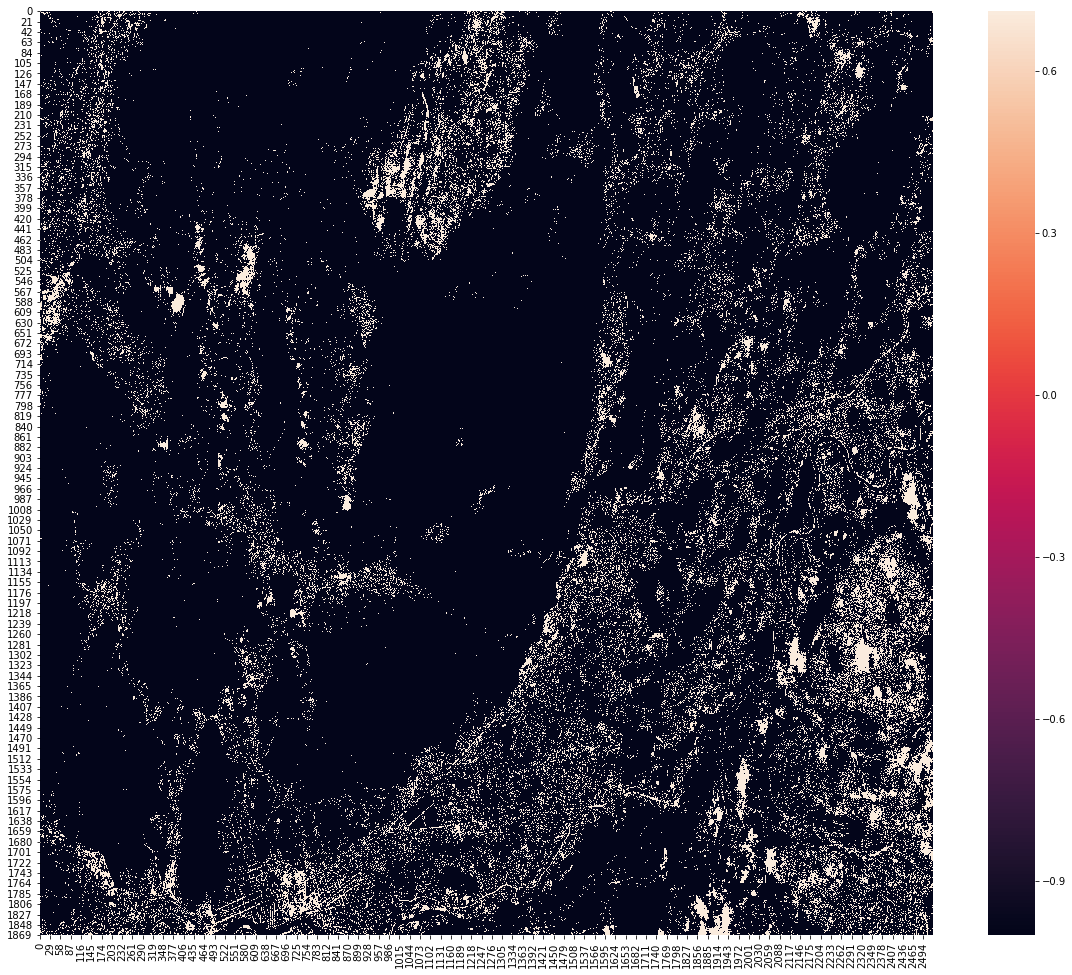

In [25]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

In [28]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (-1.455224, 30.323259) # rwanda2
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
#coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (-20.147320, -40.837770) # ESPERITO SANTO BR 2
#coords = (44.865106, -123.093435) # salem, oregon
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (4.179529, -74.889171) # , colombia
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.727334, -90.015579) # elsalvador imposible
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania
#coords = (12.398014, -86.963042) # Nicaragua


coords = (coords[1], coords[0])
print(coords)
point = bounding_box(coords, (20*1260)-20, (15*1260)-30, expansion = 0) # -85, +135 el salv
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

(14.2722, 10.596)
[25180.0, 18870.0]


In [29]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/cameroon.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

# Cloud optimized Geotiff

In [34]:
!gdal_translate ../../ce-hosting/includes/cameroon.tif cameroon.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro cameroon.tif 2 4 8 16 32

Input file size is 2520, 2520
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


# Half-hectare tree density Geotiff

In [261]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.7)
summed += 0.1

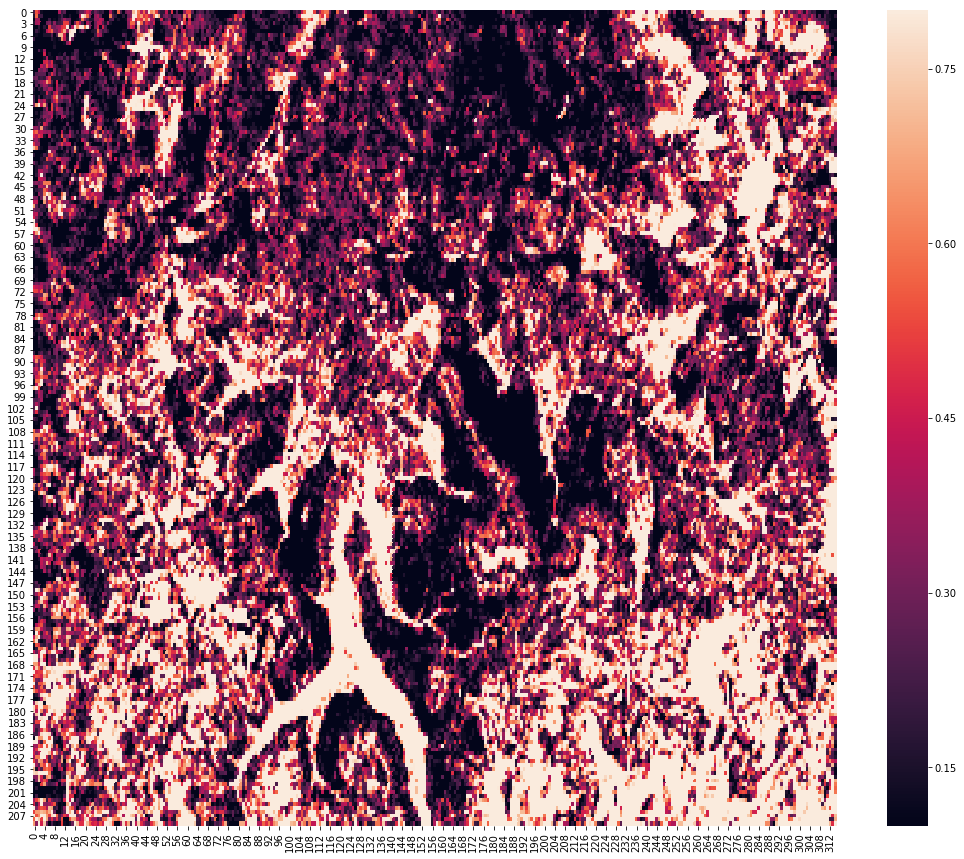

In [40]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [41]:
np.min(summed)

0.1

In [42]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/tigray1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()